<a href="https://colab.research.google.com/github/marcinwolter/MedicalPictures/blob/master/figure_jpeg_cnn_reco_jpeg2000_nearest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code generating geometrical figures and performing pattern recognition using Deep NN

*Feb. 2020, Marcin Wolter*

In [1]:
'''Trains a simple convnet on the generated set of figures (circle, triangle, square)
'''
from __future__ import print_function

#install KERAS if not there
!pip install keras_sequential_ascii

import matplotlib.pyplot as plt
import matplotlib.pylab as pyl
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation
from keras import backend as K
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.utils import plot_model
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import metrics

from PIL import Image, ImageDraw

import time
import math



  Created wheel for keras-sequential-ascii: filename=keras_sequential_ascii-0.1.1-cp36-none-any.whl size=3062 sha256=fde6ff8b97857caabdfdf87060d8815a3b48de6e590ada61e3be27cd57bb6f5d
  Stored in directory: /root/.cache/pip/wheels/f5/8d/81/912666dff82a923ce423a7e797cd75f54271c7031512cdb282
Successfully built keras-sequential-ascii


Using TensorFlow backend.


Prevent Google Colab from disconnecting

In [2]:
from IPython.display import display, HTML
js = ('<script>function ConnectButton(){ '
           'console.log("Connect pushed"); '
           'document.querySelector("#connect").click()} '
           'setInterval(ConnectButton,3000);</script>')
display(HTML(js))

# **Setup the parameters**

In [3]:
# DNN parameters
batch_size = 128
# number of classes
num_classes = 2
epochs = 256 #12

np.random.seed(2348)

#batch_size_gen = 60000
#batch_size_val = 10000
batch_size_gen = 60000
batch_size_val = 10000

# input image dimensions
img_rows, img_cols = 32, 32
img_shape = (img_rows, img_cols)


#probability of noise and its max. brithness 
prob_noise = 1.0
ampl_noise = 0.3


# figure min and max brithness
fig_min_gray=0.4
fig_max_gray=0.9

#figure sizes
# circle radius
rmin = 0.06
rmax = 0.15
# triangle/rectangle size
dmin = 0.10
dmax = 0.30
# colon / line dot radius in pixels
rpix_min = 0.5
rpix_max = 3

# distortion type
###distortion = "blur"
distortion = "jpeg"
# jpeg_format: jpeg / JPEG2000   - WARNING:  JPEG 2000 does not work on Kaggle!!!!
#jpeg_format = "jpeg"
jpeg_format = 'JPEG2000'
#jpeg_format="jpx"
# distortion - bluring sigma
sigma = (1.8,1.8)
#jpeg compression
jpeg_compression_list = [97, 80, 32, 15, 7, 3]   
jpeg2000_compression_list = [[1],[2],[4],[8],[16],[32]] 


# extrapolate True/False
extrapolate = True
# list of extrapolation factors
extrapolation_list = [0.50, 1., 2.]
###extrapolation_list = [1.]

# Generated 32x32 small image is pasted on a big image, which is a subject of
# graphical operations (jpeg compression, scaling etc). Then it is cropped out
# of it. The big image size is defined here:
bigIm_shape = (512, 512)
smallIm_X = 240
smallIm_Y = 240
# number of images to test the size
n_big = 500

#resample method BICUBIC/NEAREST/BILINEAR
#method = Image.BICUBIC
#method = Image.BILINEAR
method = Image.NEAREST

#Remove the saved DNN
! rm best_model.h5
# make directory to store images
! mkdir images
! rm images/*

rm: cannot remove 'best_model.h5': No such file or directory
rm: cannot remove 'images/*': No such file or directory


# **Generate noise**

In [0]:
def gen_noise(batch_size_gen=batch_size_gen, img_shape=img_shape, prob_noise=prob_noise):

        batch_events = np.zeros((batch_size_gen, 1, img_shape[0], img_shape[1]))
        for n in range(batch_size_gen):

            for i in range(img_shape[0]):
               for j in range(img_shape[1]):
                 if np.random.random()<prob_noise:
                     batch_events[n,0,i,j]= min(1.,max(0.,ampl_noise*np.random.randn()))


        yield batch_events


#  Generate geometrical figures - circle, triangle, square, colon, line

In [0]:

### generate geometrical figures

def generate_circle(r, x0, y0, img_shape):
    """
    Generate a single circle.
    Parameters:
        r: radius
        x0,y0: position of the circle center
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 10x10 pixels, 1 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.ellipse((x0-r, y0-r, x0+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255
    
    #print(x)
    return x

In [0]:
def generate_square(d, x0, y0, angle, img_shape):
    """
    Generate a square.
    Parameters:
        d: size
        x0,y0: position of the square center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.rectangle((x0-d/2, y0-d/2, x0+d/2, y0+d/2), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x




In [0]:
def generate_triangle(d, x0, y0, angle, img_shape):
    """
    Generate a triangle.
    Parameters:
        d: size 
        x0,y0: position of the triangle center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel grayscale
    draw = ImageDraw.Draw(image)
    dd = d/math.sqrt(3)
    draw.polygon(((x0-d/2, y0-dd/2), (x0+d/2, y0-dd/2), (x0,y0+dd)), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255.
    
    #print(x)
    return x



In [0]:
def generate_line(r, x0, y0, angle, img_shape):
    """
    Generate a line.
    Parameters:
        r: width, length = 5*r
        x0,y0: position of the line center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.rectangle((x0-2.5*r, y0-r, x0+2.5*r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x



In [0]:
def generate_colon(r, x0, y0, angle, img_shape):
    """
    Generate a colon.
    Parameters:
        r: dot radius
        x0,y0: position of the colon center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.ellipse((x0-1.5*r-r, y0-r, x0-1.5*r+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    draw.ellipse((x0+1.5*r-r, y0-r, x0+1.5*r+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x



In [0]:


# generate a random number
def rand_interval(a = 0., b = 1.):
   rnd = a + (b-a)*np.random.random()
   return rnd


# **Random figure generator**

In [0]:
# Generator for random figures
# Each image contains exactly one object (circle, triangle, square)
def gen_n_figures(batch_size_gen=batch_size_gen, img_shape=img_shape):

        batch_events  = np.zeros((batch_size_gen, 1, img_shape[0], img_shape[1]))
        batch_targets =-np.ones((batch_size_gen, 1, 1 ))

        for n in range(batch_size_gen):
            
            k = np.random.randint(0,num_classes)

            
            rpix = rand_interval(rpix_min,rpix_max)
            r = rand_interval(img_cols*rmin, img_cols*rmax)
            d = rand_interval(img_cols*dmin, img_cols*dmax) 
            l = rand_interval(img_cols*dmin, img_cols*dmax)
            x0 = rand_interval(0.33*img_cols, 0.66*img_cols)       
            y0 = rand_interval(0.33*img_rows, 0.66*img_rows)     
            alpha = 360.*np.random.random()  

            if k == 0:
               batch_events[n,0] = generate_colon(rpix, x0, y0, alpha, img_shape)
            elif k == 1:
               batch_events[n,0] = generate_line(rpix, x0, y0, alpha, img_shape)  
            elif k == 2:                
               batch_events[n,0] = generate_circle(r, x0, y0, img_shape)
            elif k == 3:
               batch_events[n,0] = generate_square(d, x0, y0, alpha, img_shape)
            elif k == 4:
               batch_events[n,0] = generate_triangle(l, x0, y0, alpha, img_shape)                             
            else:
               print("Wrong figure id!!!")
            batch_targets[n,0] = k
            


        yield batch_events, batch_targets



# **Distort an image** 
Distortion might be either bluring or a conversion to jpeg and back.

In [0]:
# Distort images
from scipy import ndimage
#PILlow package
from PIL import Image
from io import BytesIO
import scipy.misc

def distort_n_figures(images, jpeg_compression, distortion=distortion, img_shape=img_shape, sigma = sigma):
  
  if (distortion == "blur"):
    images_distorted = np.zeros((len(images), 1, img_shape[0], img_shape[1]))
    for n in range(len(images)):
     
    
      images_distorted[n,0] = ndimage.gaussian_filter(255.*images[n,0], sigma=sigma)/255.
#      images_distorted[n,0] = images[n,0]

    return -1, images_distorted

  elif (distortion == "jpeg"):
    images_distorted = np.zeros((len(images), 1, img_shape[0], img_shape[1]))
    # create a BIG image just with noise
    array_big = next(gen_noise(1, bigIm_shape ))
    image_file_size = 0

    #n_big = len(images)

    for n in range(len(images)):
        # convert to jpeg and than back
        if  (n+1)%10000==0:
           print("Distorting image ",n)

        buffer = BytesIO()
        auxIm = Image.fromarray((255.*images[n,0]).astype(np.uint8))

        if n < n_big:
           #print("array_big.shape ",array_big[0,0].shape)
           bigIm = Image.fromarray((255.*array_big[0,0]).astype(np.uint8))
           #print("bigIm.size ",bigIm.size)
           #print("auxIm.size ",auxIm.size)
           #paste auxIm into the middle of bigIm
           bigIm.paste(auxIm,(smallIm_X,smallIm_Y))
           auxIm = bigIm
        #print("auxIm.size from bigIm ",auxIm.size)

        if jpeg_format == 'jpeg':
           auxIm.save(buffer, format=jpeg_format, quality=jpeg_compression)
           if n < n_big:
              auxIm.save("images/image_extr_"+str(extrapolation_factor)+"_jpg_"+str(jpeg_compression)+"_"+str(n)+".jpg", format=jpeg_format, quality=jpeg_compression)
        elif jpeg_format == 'JPEG2000':
           auxIm.save(buffer, format=jpeg_format, quality_mode='rates', quality_layers=jpeg_compression, irreversible=True) 
           if n < n_big: 
              auxIm.save("images/image_extr_"+str(extrapolation_factor)+"_jpg_"+str(jpeg_compression)+"_"+str(n)+".jp2", format=jpeg_format, quality_mode='rates', quality_layers=jpeg_compression, irreversible=True)
        else:
           print("Unknown format %s" % jpeg_format)    

        if n < n_big:
           image_file_size = image_file_size + buffer.tell()

  
        buffer.seek(0)
        auxIm = Image.open(buffer)

        # resize image and then resize back to the original size using BICUBIC/NEAREST/BILINEAR
        if (extrapolation_factor != 1.):
           width, height = auxIm.size
           auxIm = auxIm.resize((int(extrapolation_factor*width),int(extrapolation_factor*height)),resample=method)
           #print("image size ",auxIm.size)
           auxIm = auxIm.resize((width,height),resample=method)
        
        # crop original image from the big image
        if n < n_big:
           auxIm = auxIm.crop((smallIm_X,smallIm_Y,smallIm_X+img_cols,smallIm_Y+img_rows))
        #print("Final image size ",auxIm.size)

        # add image to the array of distorted images
        images_distorted[n,0] = np.array(auxIm) / 255.  
 
    average_size = image_file_size/n_big

    return average_size, images_distorted

  else:
    return -1, images  

## **Plot some images**

In [0]:
def plot_images(plot_size=6):

  class_names = ['colon','line','circle','square','triangle']

  offset = max(0, min(batch_size_gen-plot_size*plot_size, np.random.randint(0,batch_size_gen/2)))
  plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.90, wspace=0.20, hspace=0.40)
  for n in range(min(plot_size*plot_size,len(xx_train))):
    ax = plt.subplot(plot_size, plot_size, n+1)
    ax.imshow(xx_train[n+offset,0], cmap='gray', vmin=0, vmax=1)
    ax.set_title(class_names[int(yy_train[n+offset,0])])
    ax.axis('off')

  plt.show()
  #plt.savefig('event.png')
  #plt.clf()


#plotting results of classification
def plot_results(plot_size=6):
  
  class_names = ['colon','line','circle','square','triangle']
  YY_pred = saved_model.predict(xx_val, verbose=2)
  
  offset = max(0, min(len(YY_pred)-plot_size*plot_size, np.random.randint(0,len(YY_pred)/2)))

  plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.90, wspace=0.20, hspace=0.40)
  for i in range(int(min(plot_size/2,len(YY_pred)/plot_size))):
    for n in range(int(min(plot_size,len(YY_pred)))):
      ax = plt.subplot(plot_size,plot_size,plot_size*2*i+n+1 )
      ax.imshow(xx_val[plot_size*i+n+offset,0], cmap='gray', vmin=0, vmax=1)
      ax.axis('off')

    for n in range(min(plot_size,len(YY_pred))):
      ax = plt.subplot(plot_size,plot_size,plot_size*2*i+plot_size+n+1)
      x = np.arange(num_classes)
      ax.bar(x, height = YY_pred[plot_size*i+n+offset,0], tick_label = class_names[0:num_classes]) 
      ax.axis('off')
#      ax.set_title(class_names[int(np.argmax(YY_pred,axis=2)[plot_size*i+n+offset])])
      ax.set_title(class_names[int(np.argmax(yy_val,axis=2)[plot_size*i+n+offset])])
#      print("yy_val",np.argmax(yy_val,axis=2))
#      print("YY_pred",np.argmax(YY_pred,axis=2))
  
  plt.show()
  #plt.savefig('event.png')
  #plt.clf()


# **Generate training and test data**

In [0]:
def generate_datasets():

   #generate training and validation dataset
   xx_train, yy_train = next(gen_n_figures(batch_size_gen, img_shape))
   xx_test, yy_test   = next(gen_n_figures(batch_size_val, img_shape))
   xx_val, yy_val     = next(gen_n_figures(batch_size_val, img_shape))

   print("Figures created")

   # add noise
   xx_train = xx_train + next(gen_noise(batch_size_gen, img_shape))
   xx_test  = xx_test  + next(gen_noise(batch_size_val, img_shape))
   xx_val   = xx_val  + next(gen_noise(batch_size_val, img_shape))

   print("Noise added")

   #and distort an image
   av_size_train, xx_train = distort_n_figures(xx_train, jpeg_compression)
   av_size_test, xx_test  = distort_n_figures(xx_test, jpeg_compression)
   av_size_val, xx_val   = distort_n_figures(xx_val, jpeg_compression)

   print("Images distorted")
   
   #and clip to get maximum 1
   xx_train = np.clip(xx_train, 0, 1)
   xx_test  = np.clip(xx_test, 0, 1)
   xx_val   = np.clip(xx_val, 0, 1)

 
   return xx_train, xx_test, xx_val, yy_train, yy_test, yy_val, av_size_train

# **Draw confussion matrix**

In [0]:
# Confusion matrix result

def draw_confussion_matrix():

   from sklearn.metrics import classification_report, confusion_matrix
   YY_pred = saved_model.predict(xx_val, verbose=2)
   yy_pred = np.argmax(YY_pred, axis=2)

   yy_test2 = np.argmax(yy_test, axis=2)



   #confusion matrix
   cm = confusion_matrix(np.argmax(yy_val,axis=2),yy_pred)
   print(cm)

   # Visualizing of confusion matrix
   import seaborn as sn
   import pandas  as pd


   df_cm = pd.DataFrame(cm, range(num_classes),range(num_classes))
   plt.figure(figsize = (10,7))
   sn.set(font_scale=1.4)#for label size
   sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
   plt.show()



# **Plot training results**

In [0]:

# Plots for training and testing process: loss and accuracy
def plot_training_results(cnn):

   n_epochs = len(cnn.history['loss'])

   plt.figure(0)
   plt.plot(cnn.history['categorical_accuracy'],'r')
   plt.plot(cnn.history['val_categorical_accuracy'],'g')
   plt.xticks(np.arange(0, n_epochs, 10.0))
   plt.rcParams['figure.figsize'] = (8, 6)
   plt.xlabel("Num of Epochs")
   plt.ylabel("Accuracy")
   plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
   plt.legend(['train','validation'])

   plt.figure(1)
   plt.plot(cnn.history['loss'],'r')
   plt.plot(cnn.history['val_loss'],'g')
   plt.xticks(np.arange(0, n_epochs, 10.0))
   plt.rcParams['figure.figsize'] = (8, 6)
   plt.xlabel("Num of Epochs")
   plt.ylabel("Loss")
   plt.title("Training Loss vs Validation Loss")
   plt.legend(['train','validation'])
   plt.show()





# **Define Deep Neural Network**

In [0]:
# Define Model

def base_model():

    model = Sequential()
    input_shape=(1,img_rows,img_cols)

    model.add(Reshape((img_rows,img_cols,1),input_shape=input_shape))


    model.add(Conv2D(img_rows, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(img_rows,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(2*img_rows,(3,3),padding='same',activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(2*img_rows,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(4*img_rows,(3,3),padding='same',activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(4*img_rows,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(rate = 0.2))
    model.add(Dense(32*img_rows,activation='relu',kernel_constraint=maxnorm(3))) #1024
    model.add(Dropout(rate = 0.3))
    model.add(Dense(32*img_rows,activation='relu',kernel_constraint=maxnorm(3))) #1024
    model.add(Dropout(rate = 0.3))


    model.add(Dense(num_classes, activation='softmax'))

    model.add(Reshape((1,num_classes),input_shape=(num_classes,)))

#    sgd = SGD(lr = 0.1, decay=1e-6, nesterov=True)
#    sgd = SGD(lr = 0.01, decay=1e-6, nesterov=True)

# Compile model

    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[metrics.categorical_accuracy])   # 'accuracy'

    return model



# **Visualize the network**





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496    

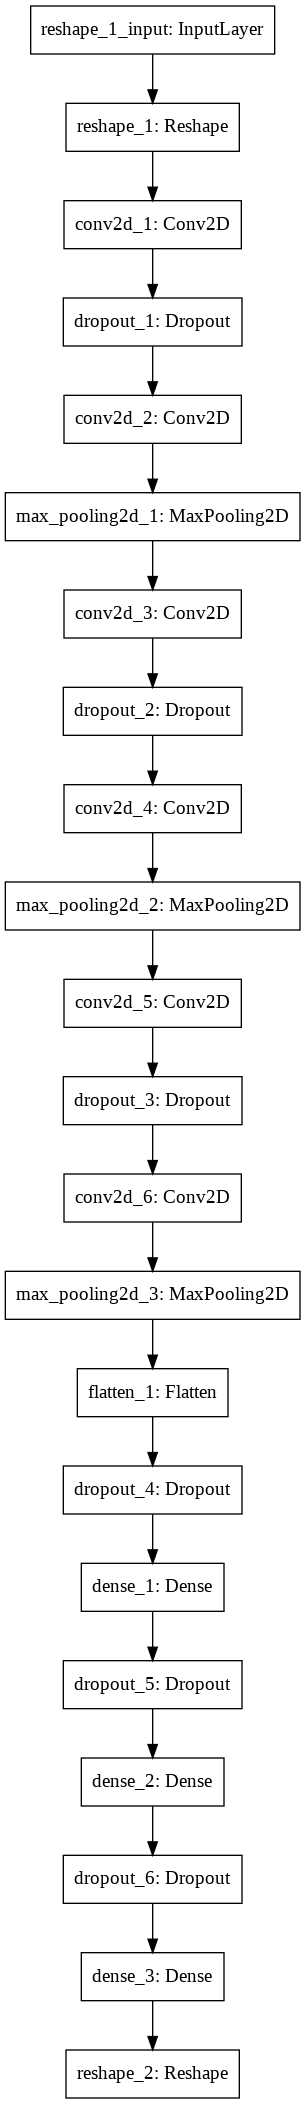

In [18]:

# Vizualizing model structure
# Model summary (ascii)
cnn_n = base_model()

cnn_n.summary()

# Model printout (ascii)
sequential_model_to_ascii_printout(cnn_n)

# Plotting model in graphical mode
plot_model(cnn_n)   ###, to_file='model.png')  ###, show_shapes=True

# **Train DNN** and display results for various jpeg qualities given in jpeg_quality_list

 
 
Extrapolation factor =  0.5
JPEG compression =  [1]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


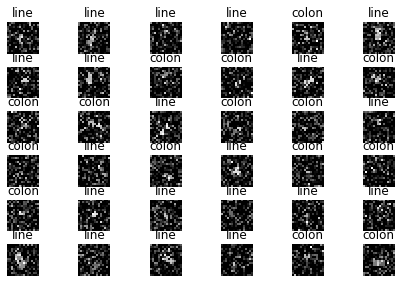

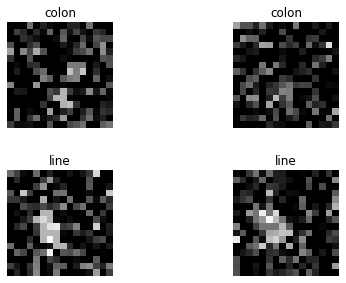

yy_train  (60000, 1, 2)
No saved model, training a new one.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









Epoch 00001: val_categorical_accuracy improved from -inf to 0.72530, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.72530 to 0.74160, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.74160

Epoch 00004: val_categorical_accuracy improved from 0.74160 to 0.75050, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy improved from 0.75050 to 0.75550, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy did not improve from 0.75550

Epoch 00007: val_categorical_accuracy improved from 0.75550 to 0.75920, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy improved from 0.75920 to 0.76170, saving model to best_model.h5

Epoch 00009: val_categorical_accuracy improved from 0.76170 to 0.76470, saving model t

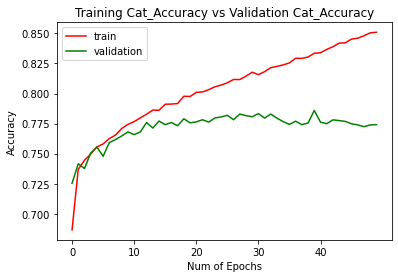

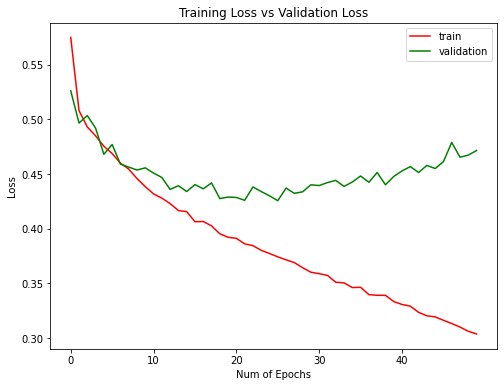

[[4211  812]
 [1418 3559]]


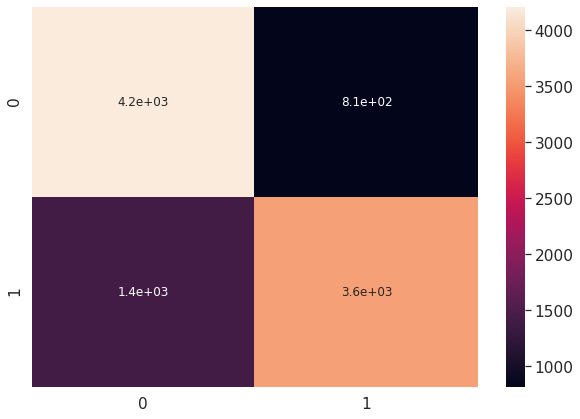

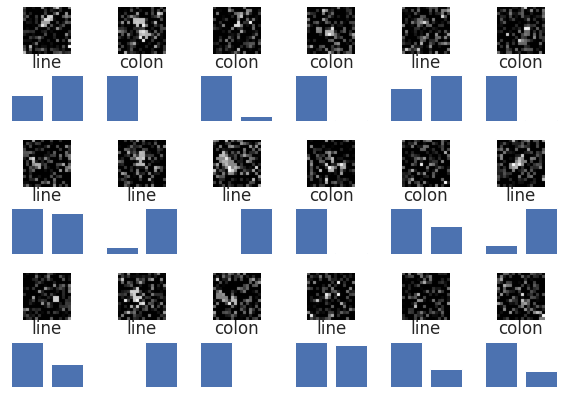

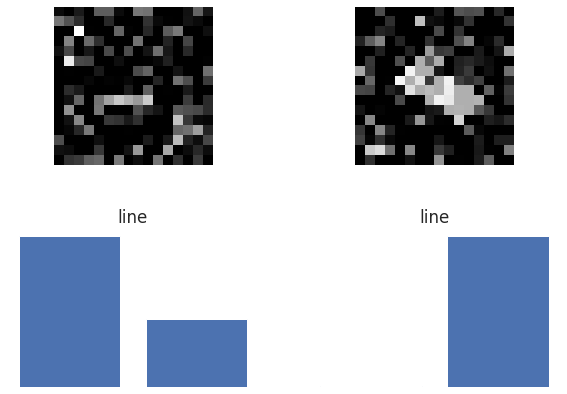

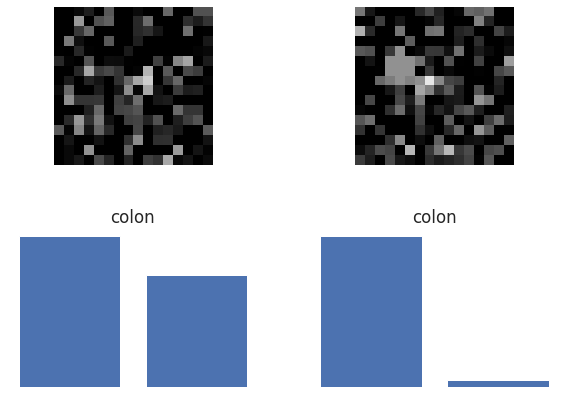

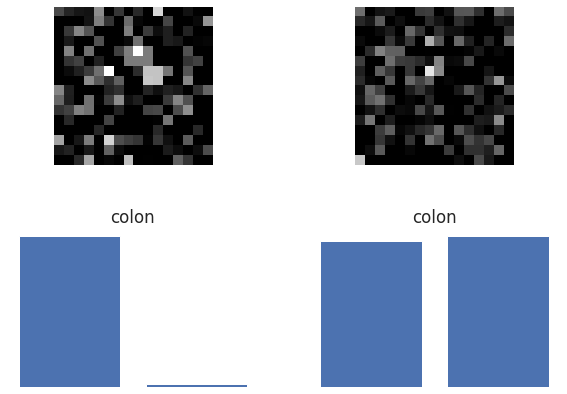

 
 
Extrapolation factor =  0.5
JPEG compression =  [2]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


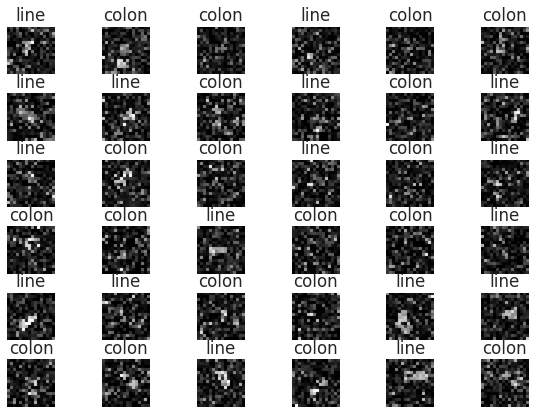

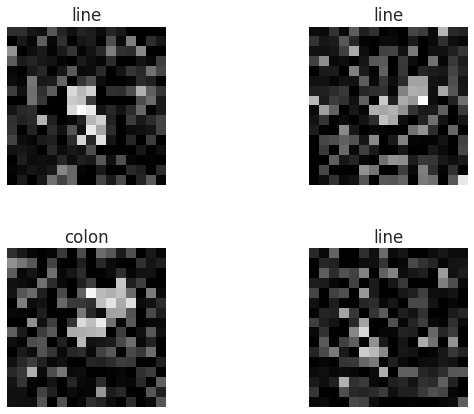

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.76260, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.76260 to 0.76990, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.76990

Epoch 00004: val_categorical_accuracy improved from 0.76990 to 0.77090, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy did not improve from 0.77090

Epoch 00006: val_categorical_accuracy did not improve from 0.77090

Epoch 00007: val_categorical_accuracy did not improve from 0.77090

Epoch 00008: val_categorical_accuracy did not improve from 0.77090

Epoch 00009: val_categorical_accuracy did not improve from 0.77090

Epoch 00010: val_categorical_accuracy did not improve from 0.77090

Epoch 00011: val_categorical_accuracy did not improve from 0.77090

Epoch 00012: val_categorical_accuracy did not improve from 0.77090

Epoch 00013: val_categorical_accuracy did not improve fro

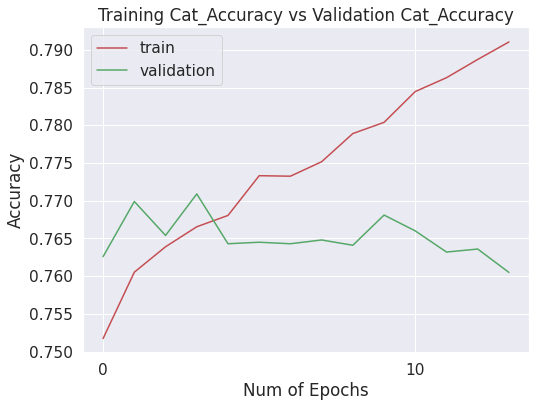

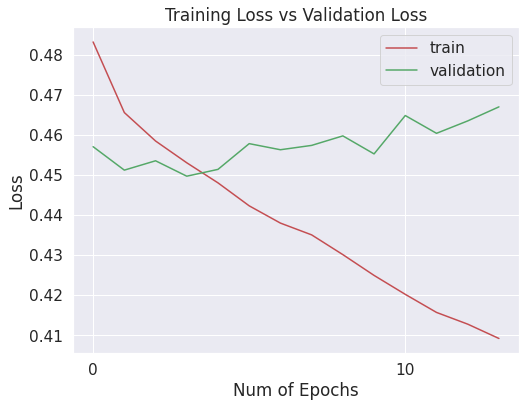

[[4131  853]
 [1491 3525]]


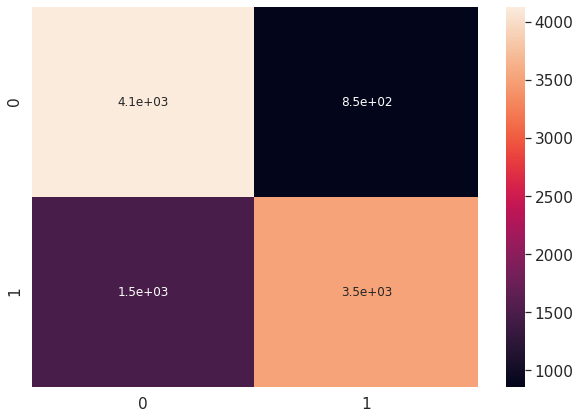

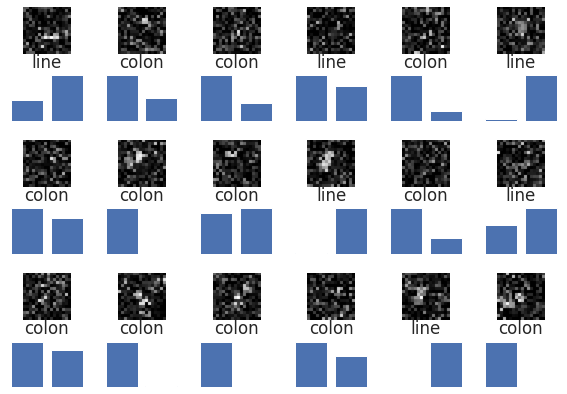

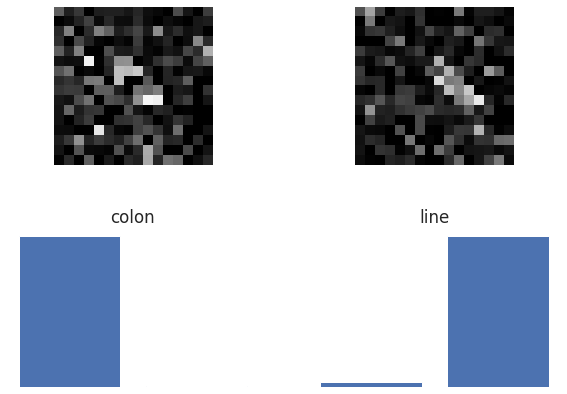

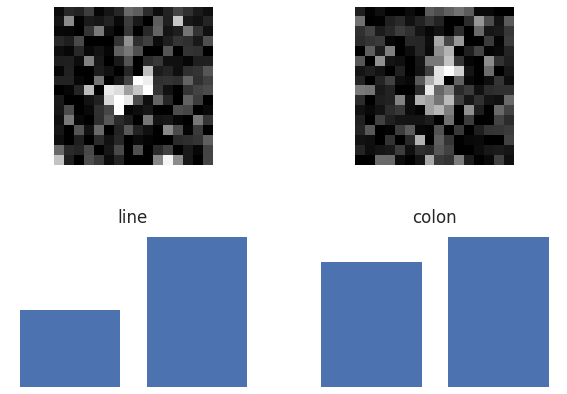

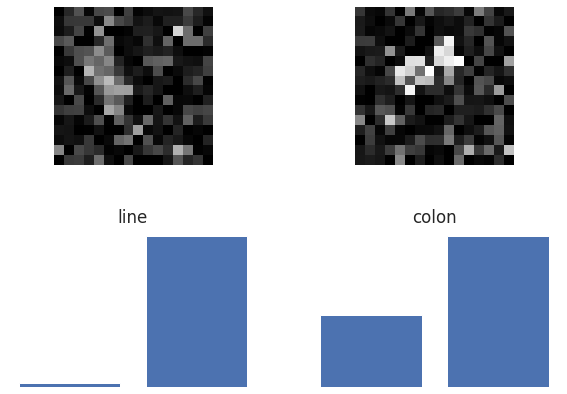

 
 
Extrapolation factor =  0.5
JPEG compression =  [4]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


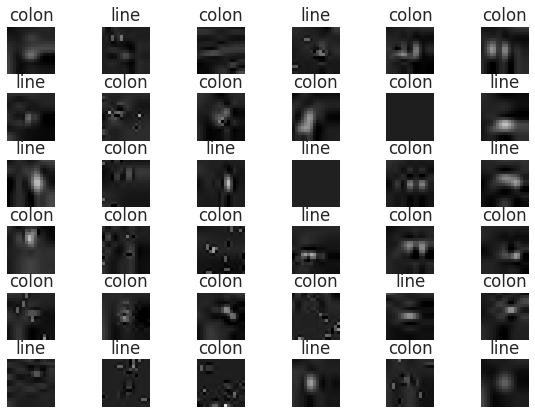

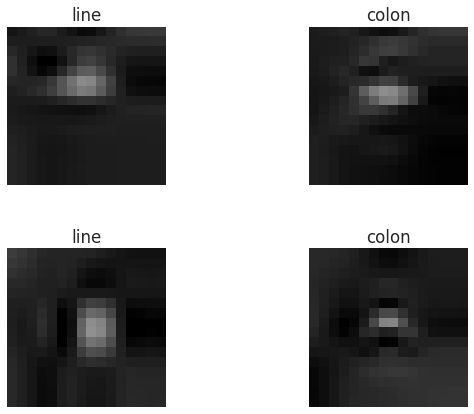

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.73120, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.73120

Epoch 00003: val_categorical_accuracy improved from 0.73120 to 0.73210, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy improved from 0.73210 to 0.73260, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy improved from 0.73260 to 0.73320, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy improved from 0.73320 to 0.73650, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy did not improve from 0.73650

Epoch 00008: val_categorical_accuracy improved from 0.73650 to 0.74040, saving model to best_model.h5

Epoch 00009: val_categorical_accuracy did not improve from 0.74040

Epoch 00010: val_categorical_accuracy did not improve from 0.74040

Epoch 00011: val_categorical_accuracy did not improve from 0.74040

Epoch 00012: val_cat

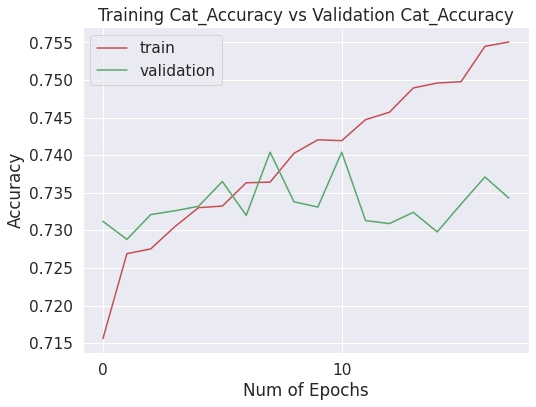

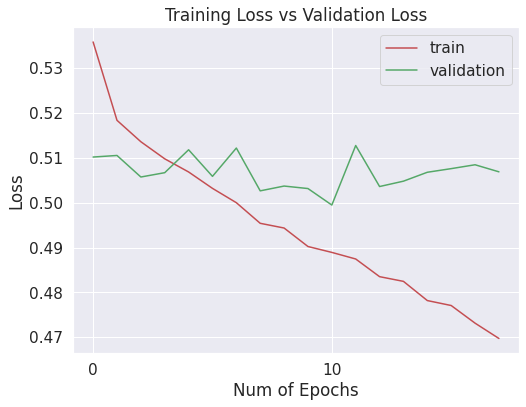

[[3738 1351]
 [1333 3578]]


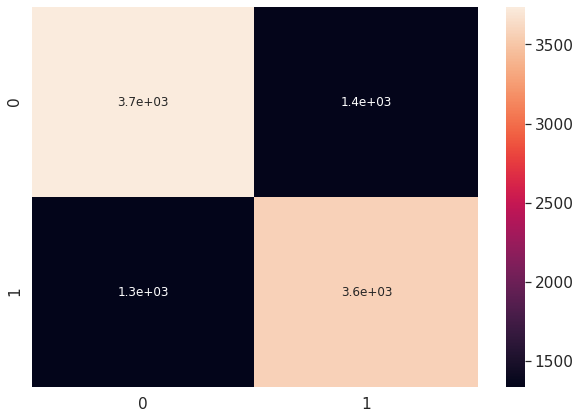

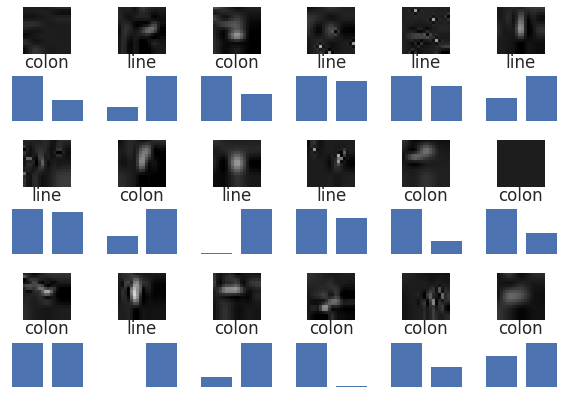

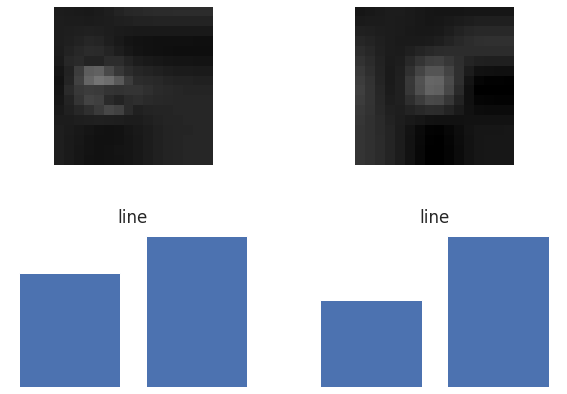

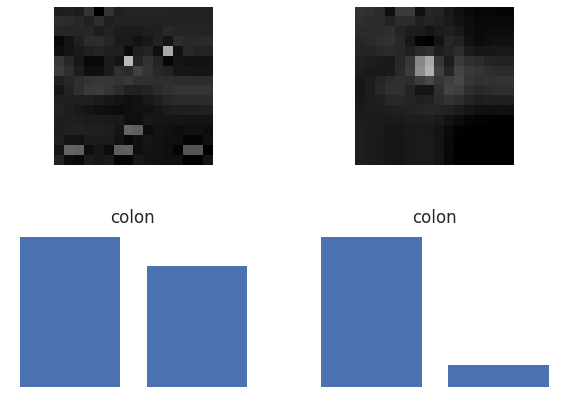

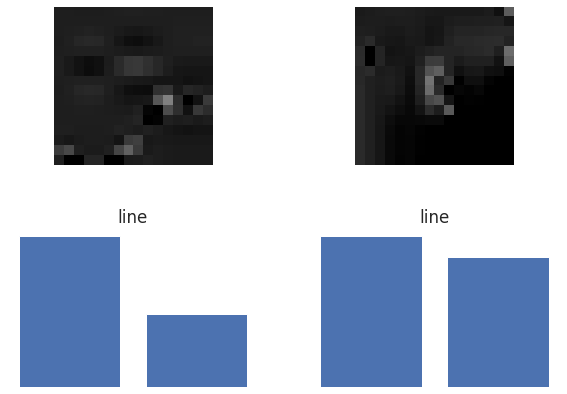

 
 
Extrapolation factor =  0.5
JPEG compression =  [8]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


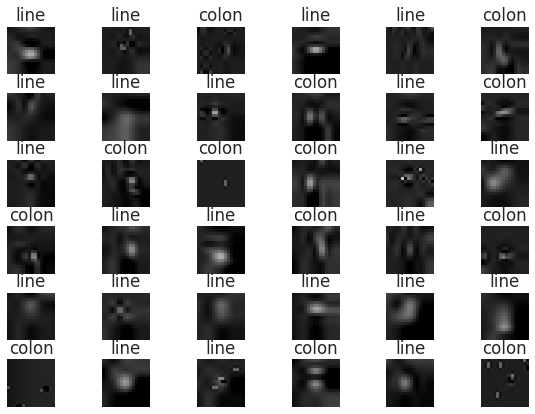

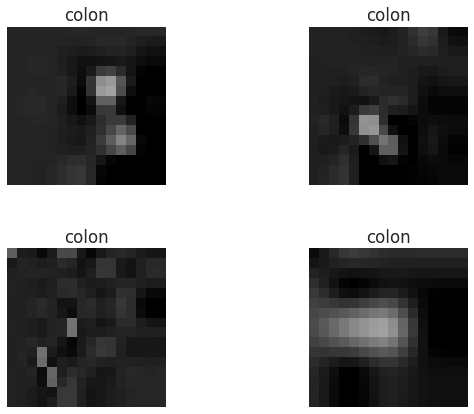

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.72020, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.72020

Epoch 00003: val_categorical_accuracy did not improve from 0.72020

Epoch 00004: val_categorical_accuracy did not improve from 0.72020

Epoch 00005: val_categorical_accuracy did not improve from 0.72020

Epoch 00006: val_categorical_accuracy did not improve from 0.72020

Epoch 00007: val_categorical_accuracy did not improve from 0.72020

Epoch 00008: val_categorical_accuracy did not improve from 0.72020

Epoch 00009: val_categorical_accuracy did not improve from 0.72020

Epoch 00010: val_categorical_accuracy did not improve from 0.72020

Epoch 00011: val_categorical_accuracy did not improve from 0.72020
Epoch 00011: early stopping
Accuracy Train: 71.09% , Test: 72.02% Val: 70.77% 


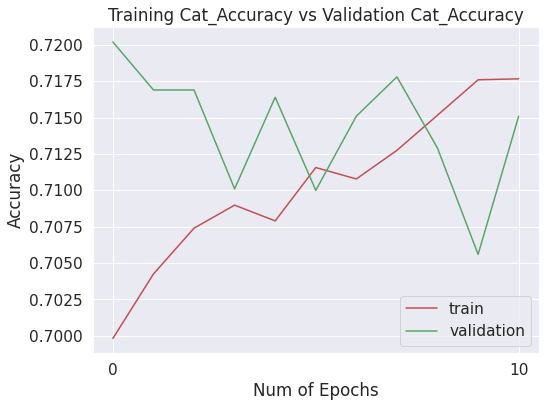

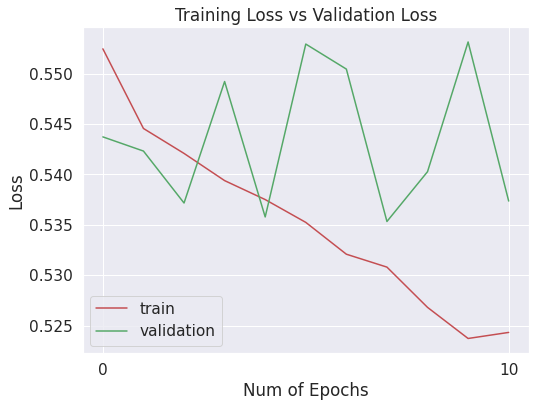

[[4053  977]
 [1946 3024]]


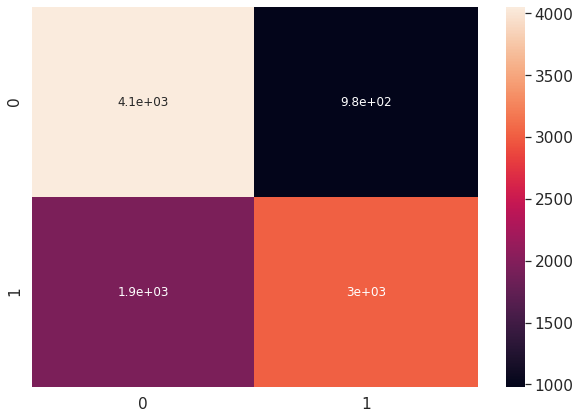

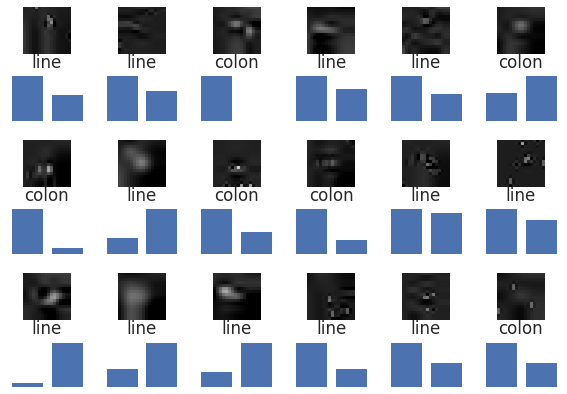

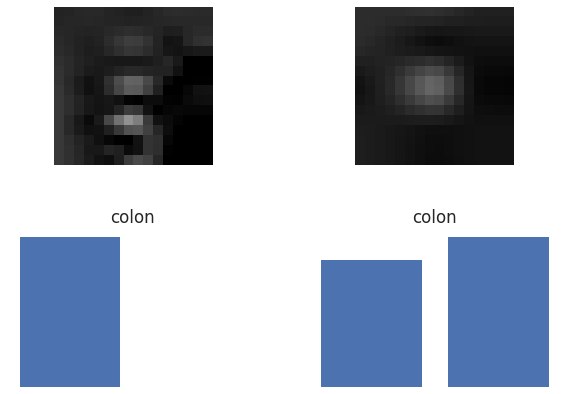

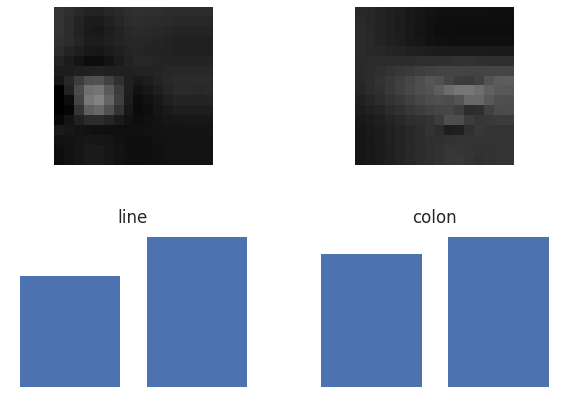

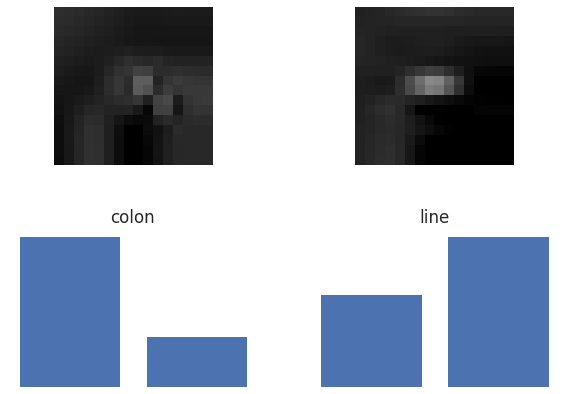

 
 
Extrapolation factor =  0.5
JPEG compression =  [16]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


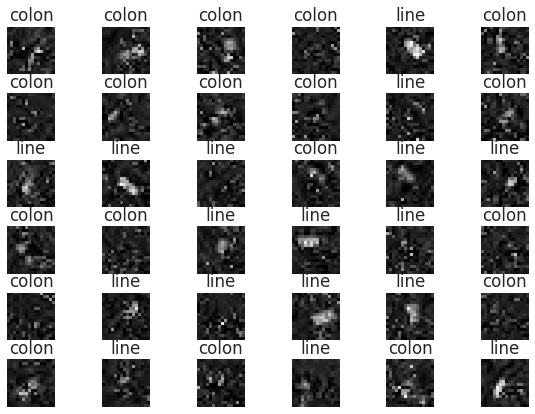

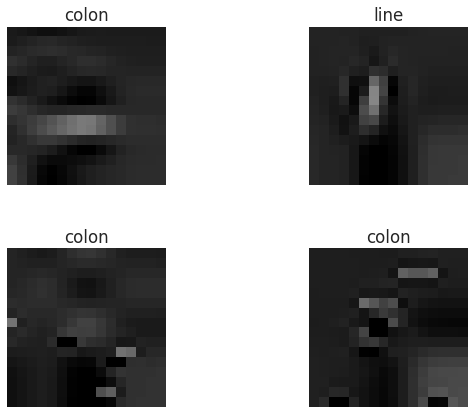

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.70630, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.70630 to 0.70730, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy improved from 0.70730 to 0.70900, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.70900

Epoch 00005: val_categorical_accuracy improved from 0.70900 to 0.71340, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy did not improve from 0.71340

Epoch 00007: val_categorical_accuracy did not improve from 0.71340

Epoch 00008: val_categorical_accuracy did not improve from 0.71340

Epoch 00009: val_categorical_accuracy did not improve from 0.71340

Epoch 00010: val_categorical_accuracy did not improve from 0.71340

Epoch 00011: val_categorical_accuracy did not improve from 0.71340

Epoch 00012: val_categorical_accuracy did not improve from 0.71340

Epoch 00013: val_categ

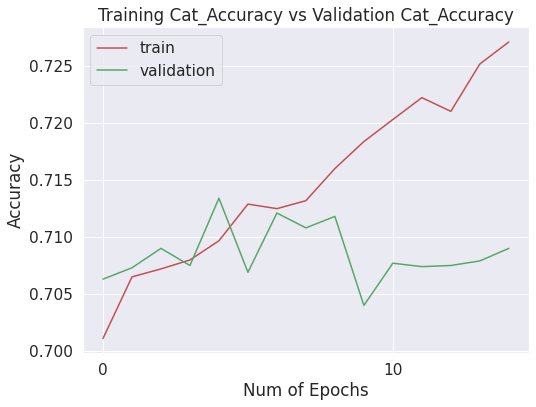

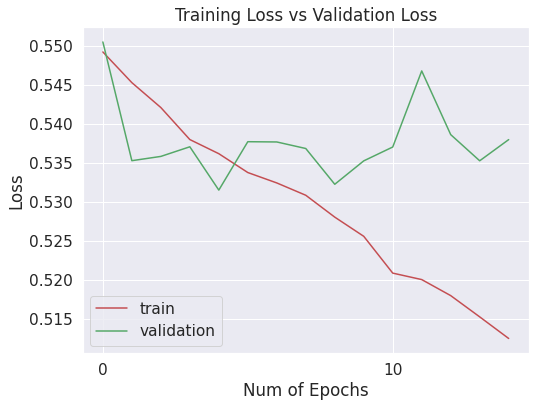

[[3524 1470]
 [1493 3513]]


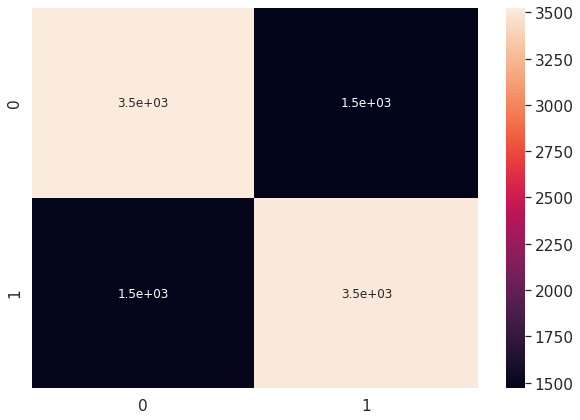

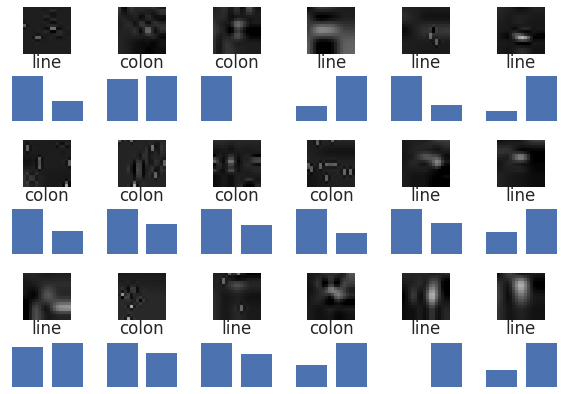

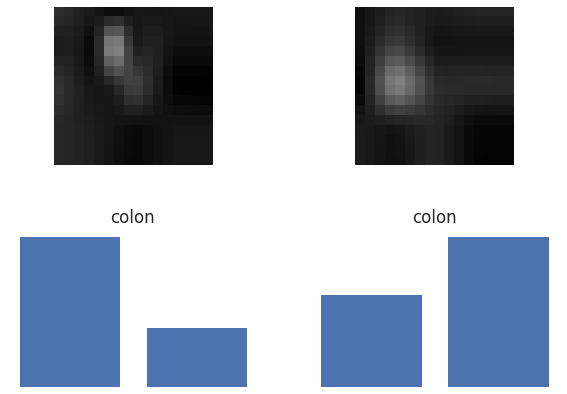

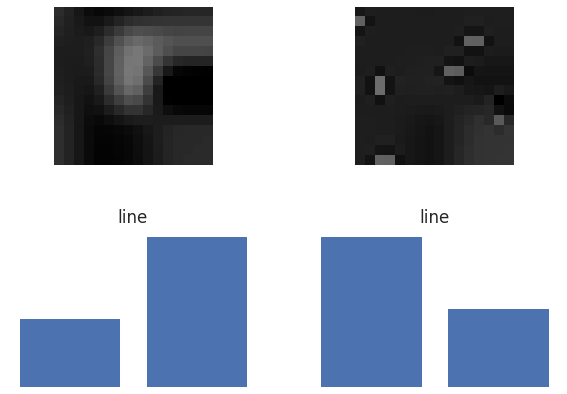

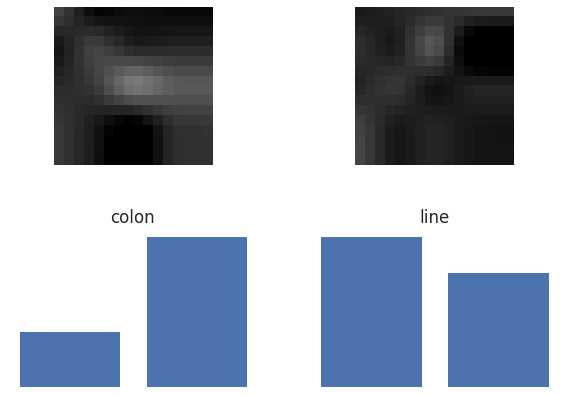

 
 
Extrapolation factor =  0.5
JPEG compression =  [32]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


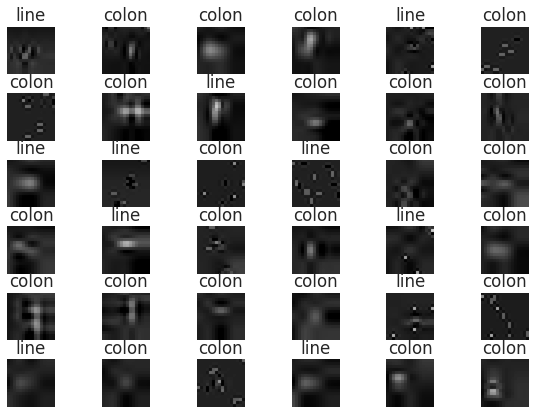

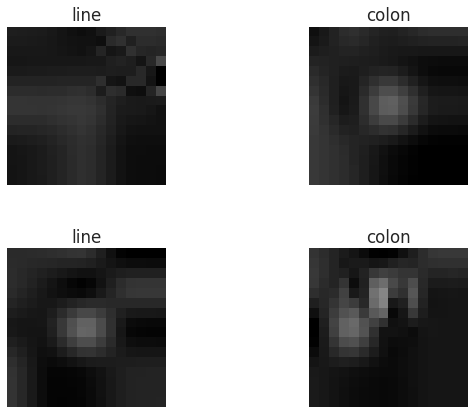

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.71020, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.71020 to 0.71210, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.71210

Epoch 00004: val_categorical_accuracy did not improve from 0.71210

Epoch 00005: val_categorical_accuracy did not improve from 0.71210

Epoch 00006: val_categorical_accuracy improved from 0.71210 to 0.71250, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy did not improve from 0.71250

Epoch 00008: val_categorical_accuracy did not improve from 0.71250

Epoch 00009: val_categorical_accuracy did not improve from 0.71250

Epoch 00010: val_categorical_accuracy did not improve from 0.71250

Epoch 00011: val_categorical_accuracy did not improve from 0.71250

Epoch 00012: val_categorical_accuracy did not improve from 0.71250

Epoch 00013: val_categorical_accuracy did not improve fro

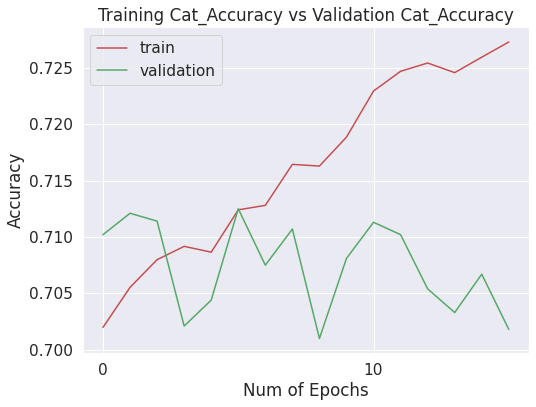

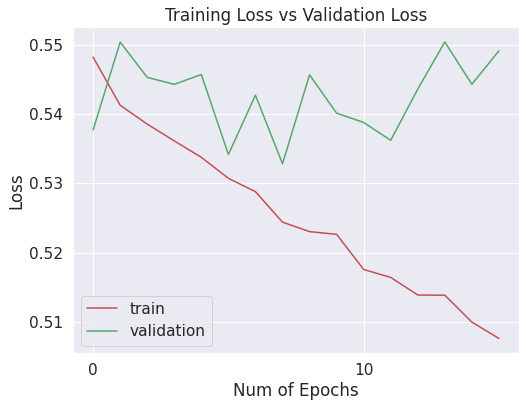

[[3726 1279]
 [1635 3360]]


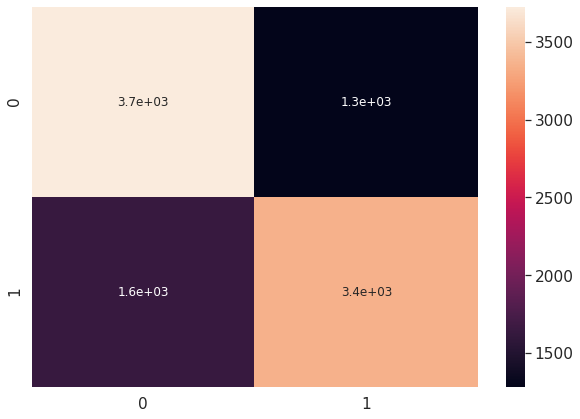

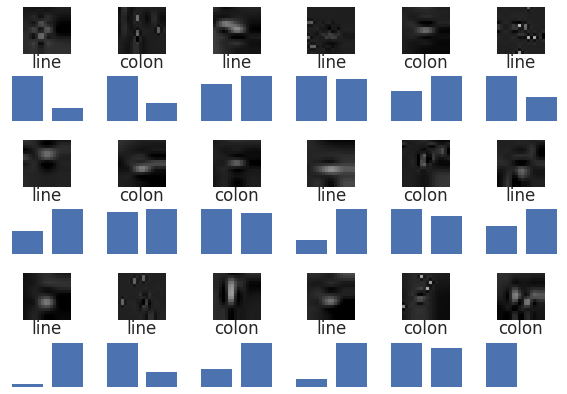

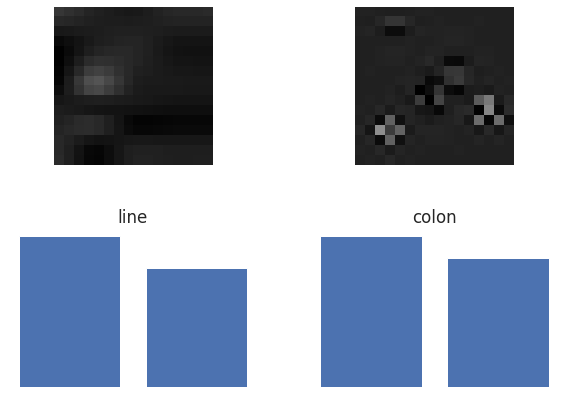

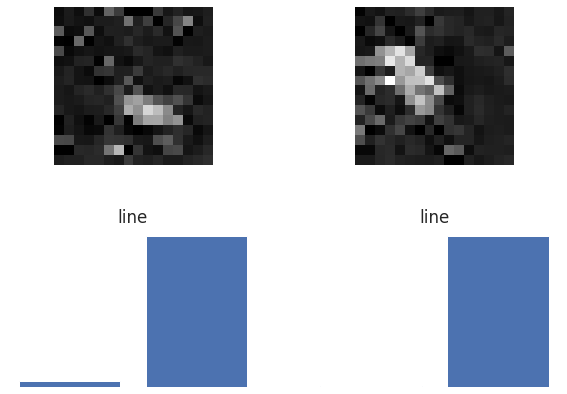

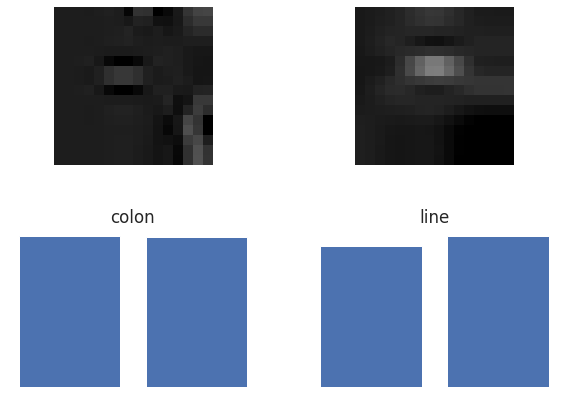

 
 
Extrapolation factor =  1.0
JPEG compression =  [1]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


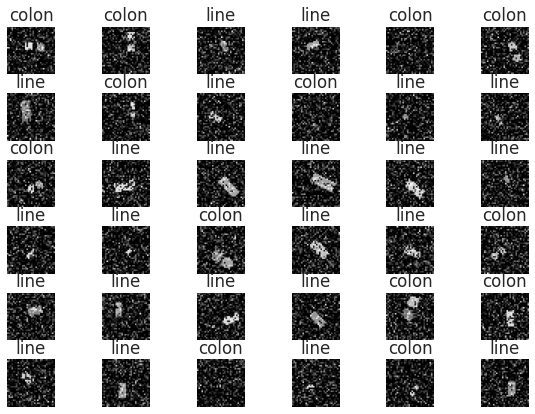

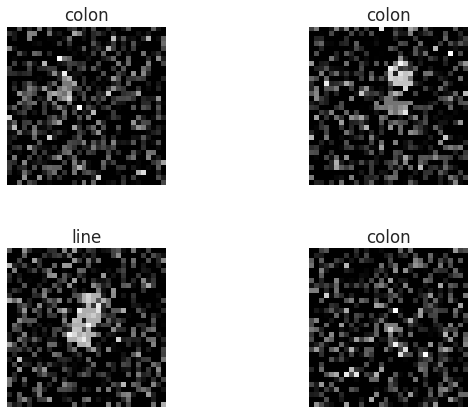

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.86190, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.86190 to 0.86900, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy improved from 0.86900 to 0.87430, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.87430

Epoch 00005: val_categorical_accuracy improved from 0.87430 to 0.87710, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy did not improve from 0.87710

Epoch 00007: val_categorical_accuracy improved from 0.87710 to 0.87950, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy improved from 0.87950 to 0.88030, saving model to best_model.h5

Epoch 00009: val_categorical_accuracy improved from 0.88030 to 0.88190, saving model to best_model.h5

Epoch 00010: val_categorical_accuracy improved from 0.88190 to 0.88480, saving model to best_model.h5

Epoch 00011: val_c

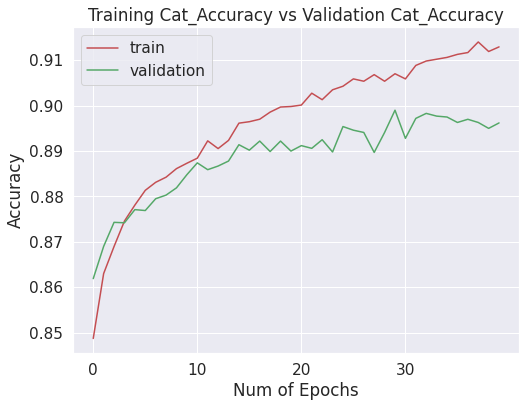

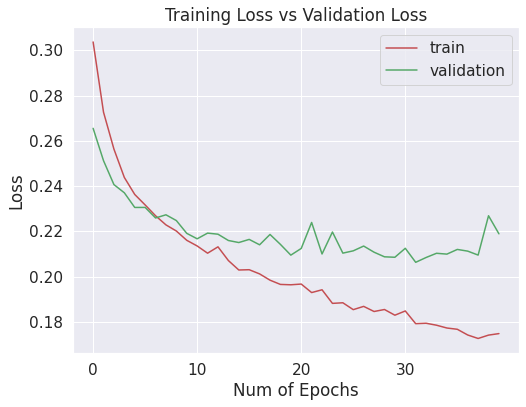

[[4380  623]
 [ 364 4633]]


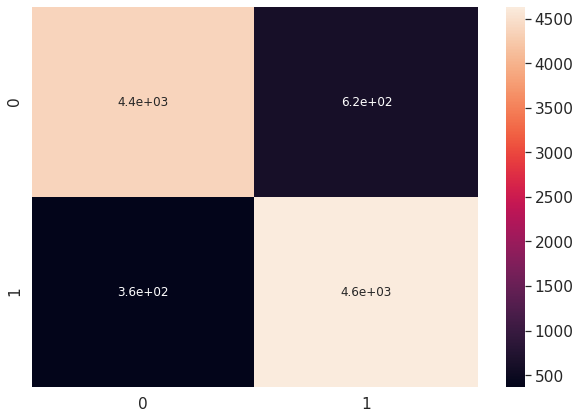

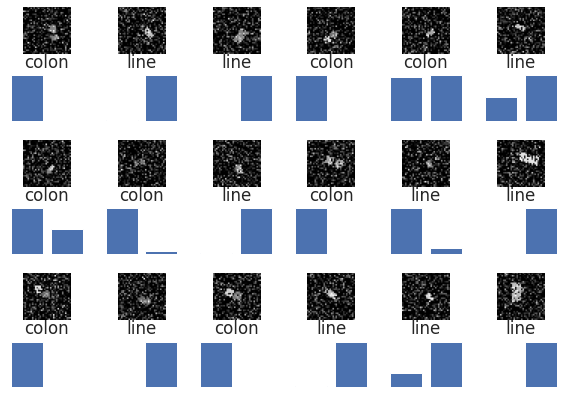

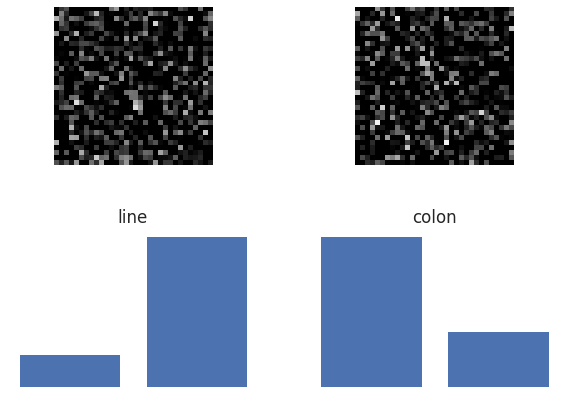

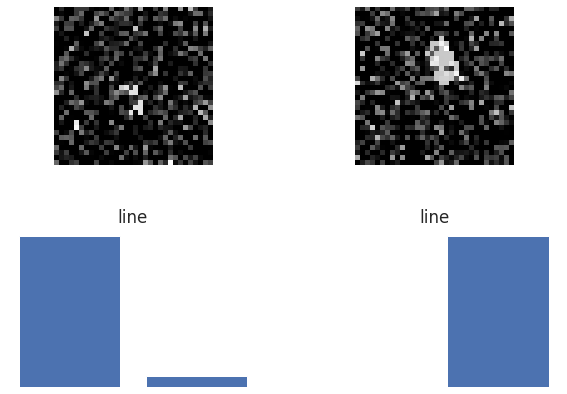

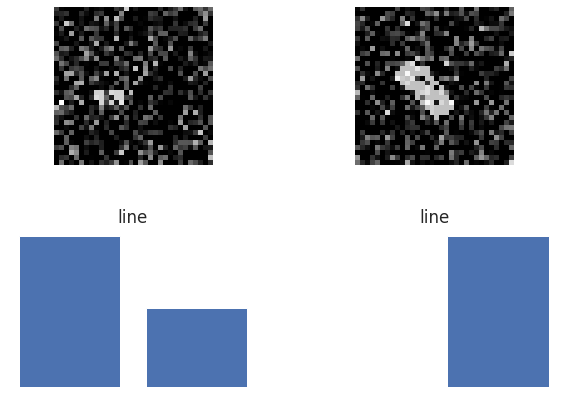

 
 
Extrapolation factor =  1.0
JPEG compression =  [2]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


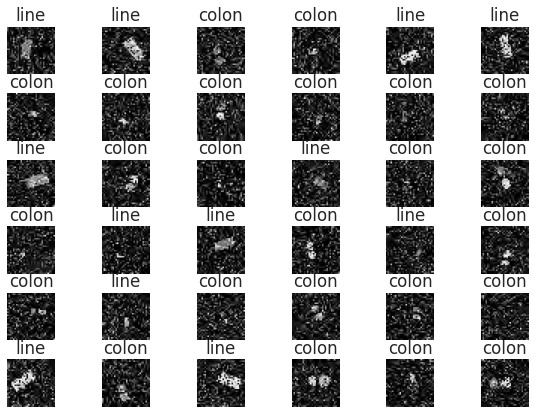

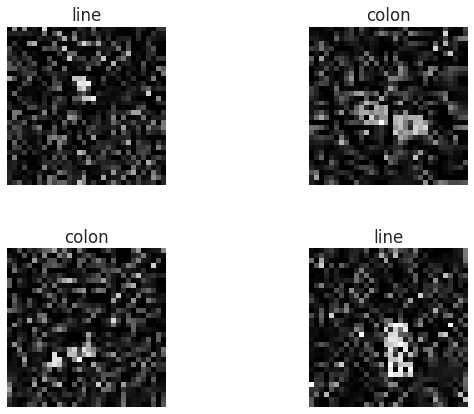

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.87860, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.87860 to 0.88210, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy improved from 0.88210 to 0.88250, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy improved from 0.88250 to 0.88720, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy improved from 0.88720 to 0.88790, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy did not improve from 0.88790

Epoch 00007: val_categorical_accuracy did not improve from 0.88790

Epoch 00008: val_categorical_accuracy improved from 0.88790 to 0.88920, saving model to best_model.h5

Epoch 00009: val_categorical_accuracy did not improve from 0.88920

Epoch 00010: val_categorical_accuracy did not improve from 0.88920

Epoch 00011: val_categorical_accuracy did not improve from 0.88920

Epoch 00012: val_cat

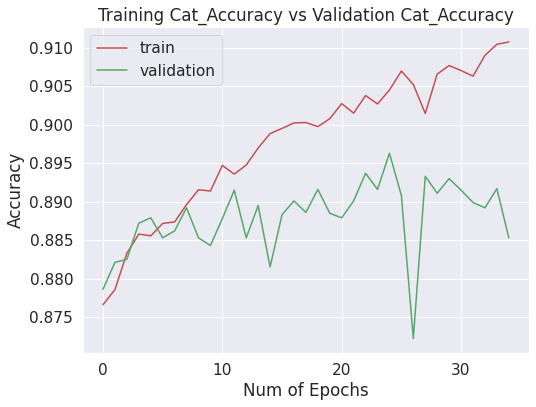

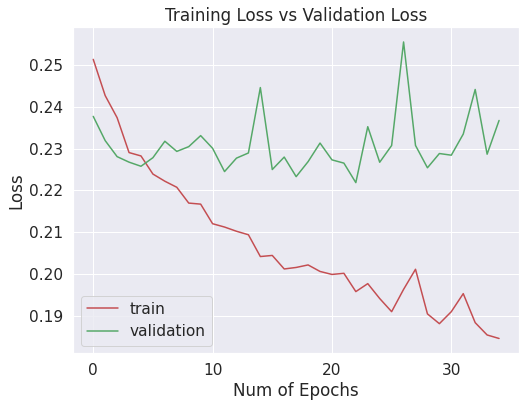

[[4393  648]
 [ 382 4577]]


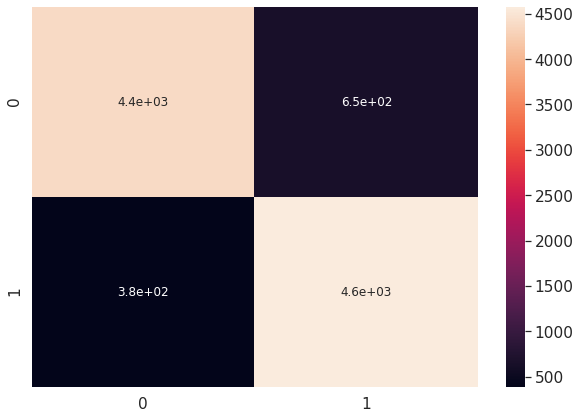

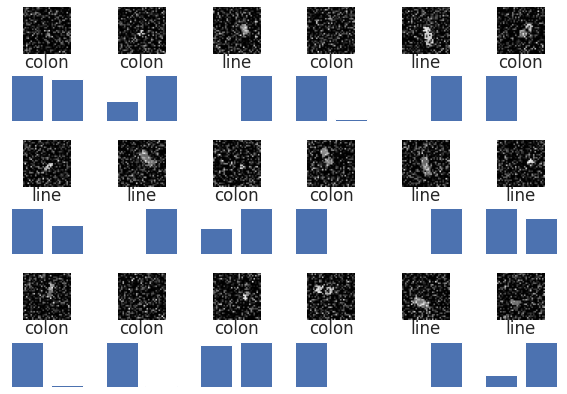

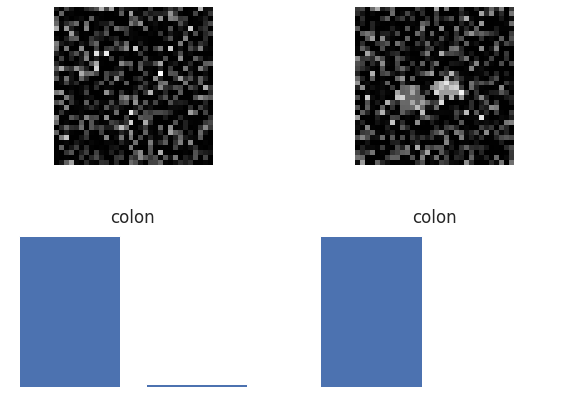

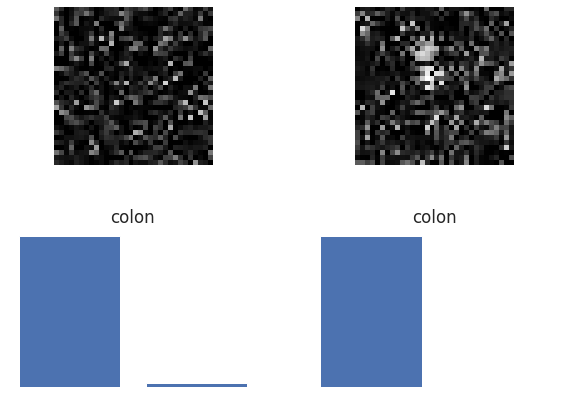

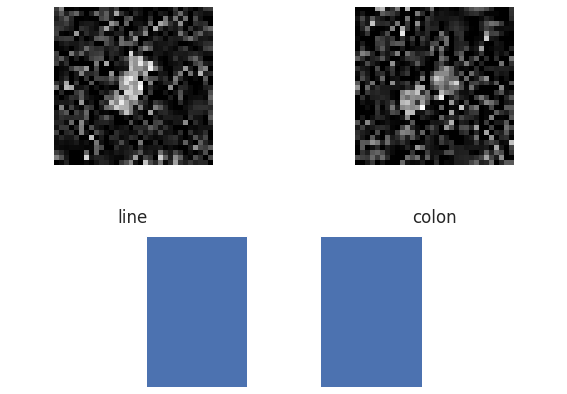

 
 
Extrapolation factor =  1.0
JPEG compression =  [4]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


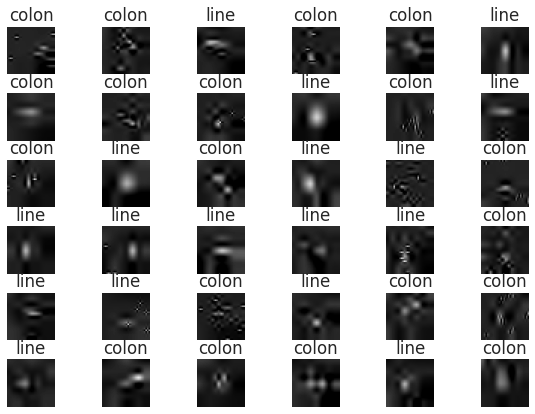

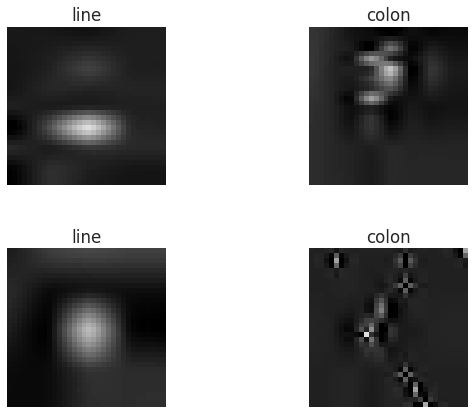

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.73750, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.73750 to 0.74390, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy improved from 0.74390 to 0.74620, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.74620

Epoch 00005: val_categorical_accuracy did not improve from 0.74620

Epoch 00006: val_categorical_accuracy improved from 0.74620 to 0.74690, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy improved from 0.74690 to 0.74990, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy did not improve from 0.74990

Epoch 00009: val_categorical_accuracy did not improve from 0.74990

Epoch 00010: val_categorical_accuracy did not improve from 0.74990

Epoch 00011: val_categorical_accuracy did not improve from 0.74990

Epoch 00012: val_categorical_accuracy did not improve f

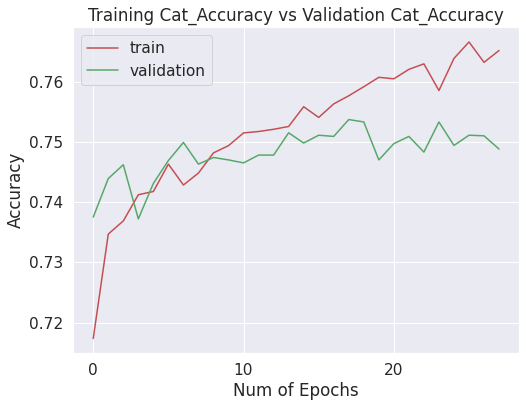

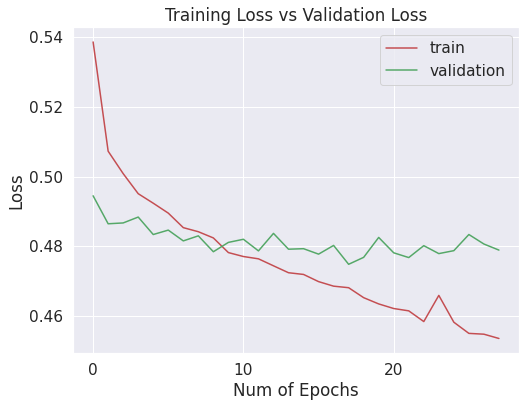

[[3738 1259]
 [1225 3778]]


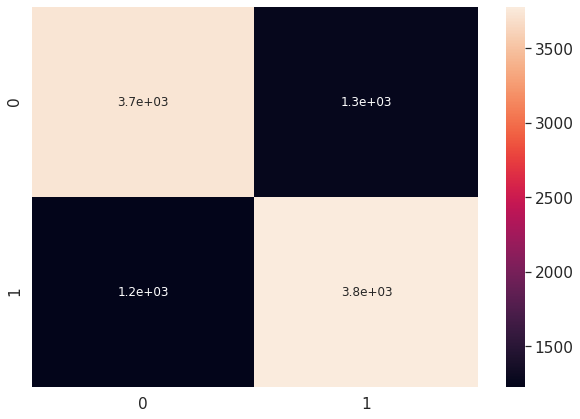

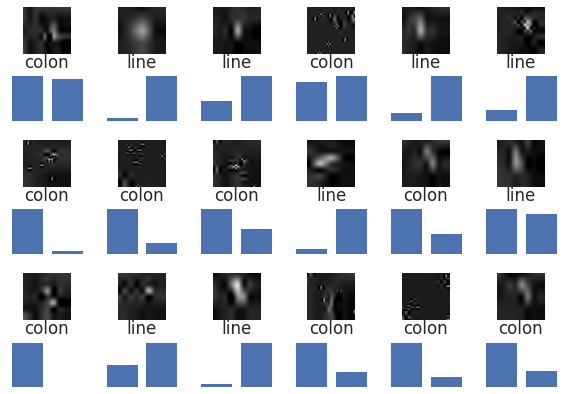

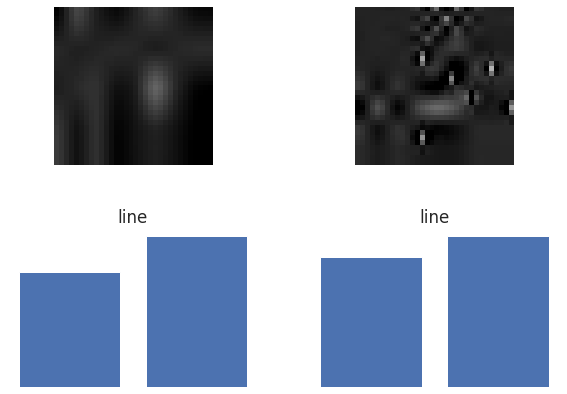

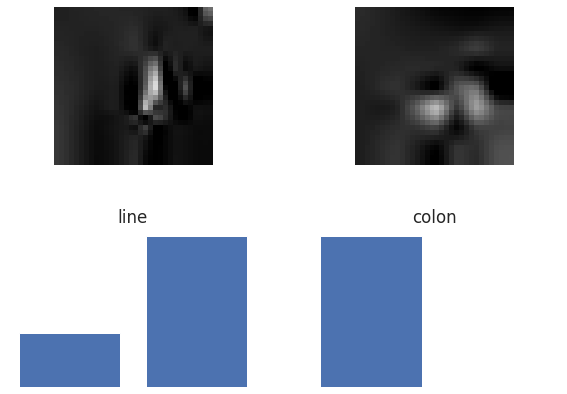

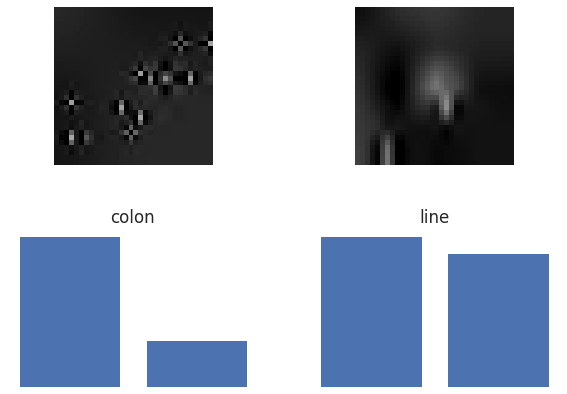

 
 
Extrapolation factor =  1.0
JPEG compression =  [8]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


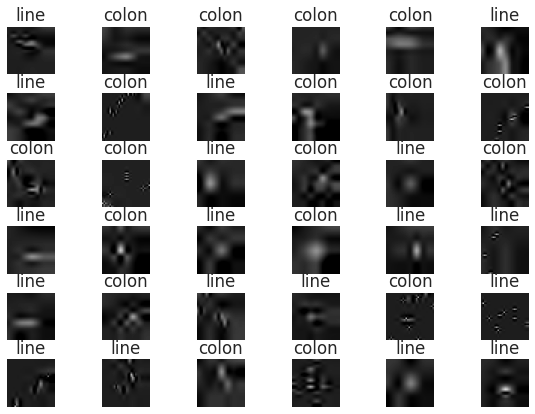

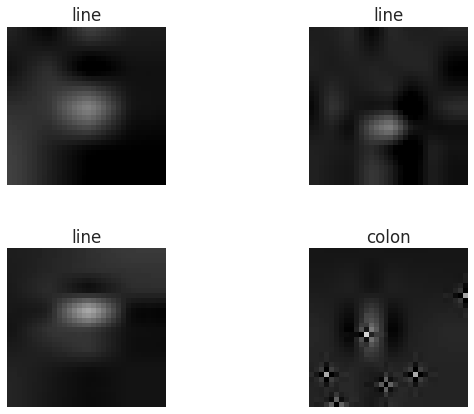

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.70860, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.70860 to 0.71490, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy improved from 0.71490 to 0.71780, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.71780

Epoch 00005: val_categorical_accuracy did not improve from 0.71780

Epoch 00006: val_categorical_accuracy did not improve from 0.71780

Epoch 00007: val_categorical_accuracy did not improve from 0.71780

Epoch 00008: val_categorical_accuracy did not improve from 0.71780

Epoch 00009: val_categorical_accuracy did not improve from 0.71780

Epoch 00010: val_categorical_accuracy did not improve from 0.71780

Epoch 00011: val_categorical_accuracy did not improve from 0.71780

Epoch 00012: val_categorical_accuracy did not improve from 0.71780

Epoch 00013: val_categorical_accuracy improved from 0.717

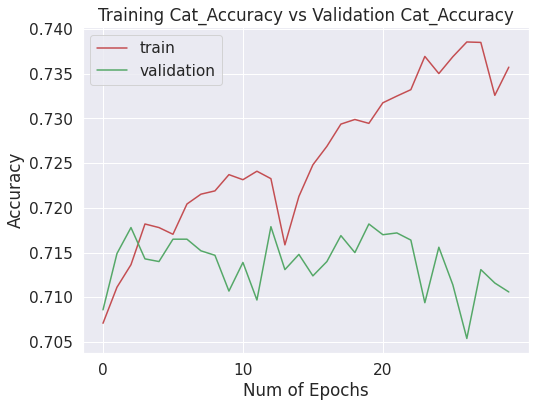

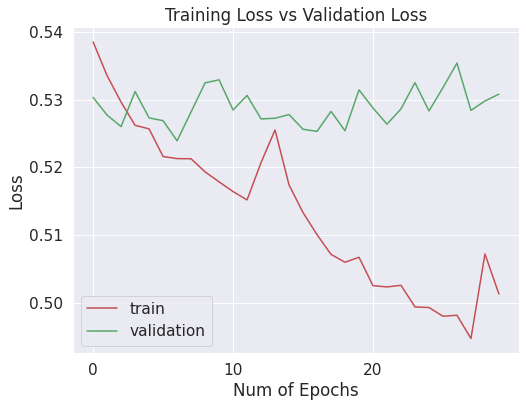

[[3687 1335]
 [1473 3505]]


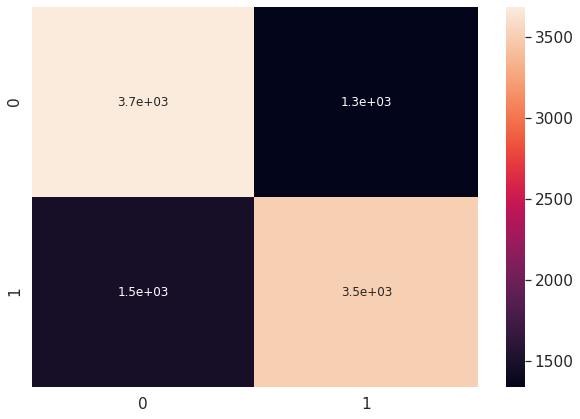

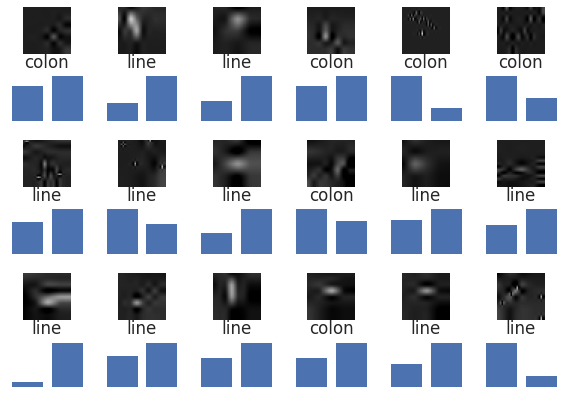

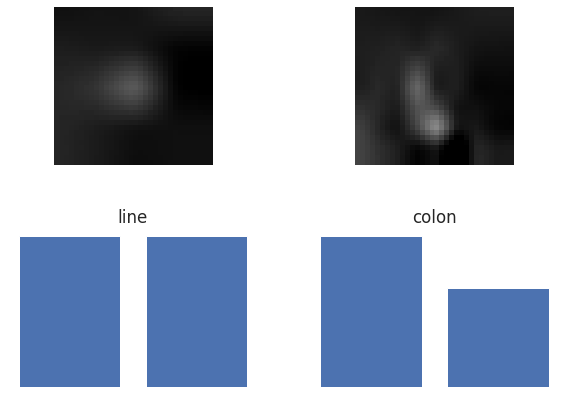

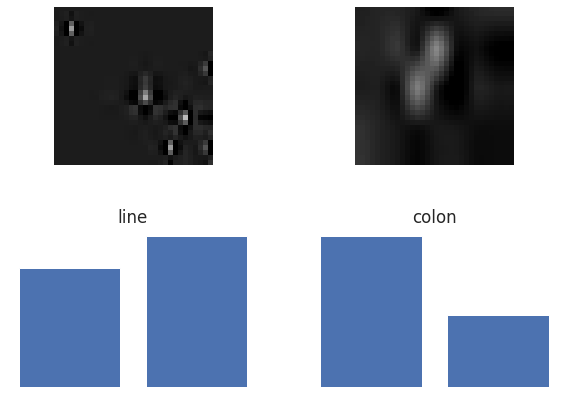

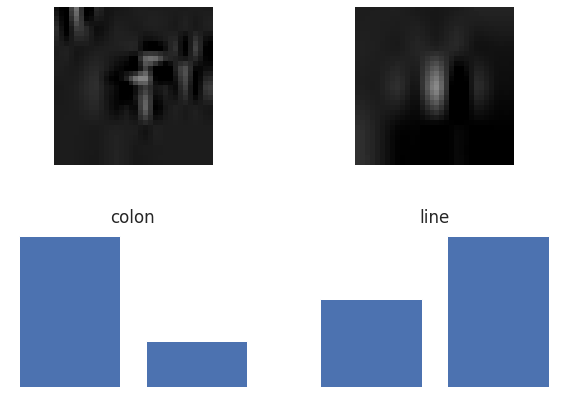

 
 
Extrapolation factor =  1.0
JPEG compression =  [16]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


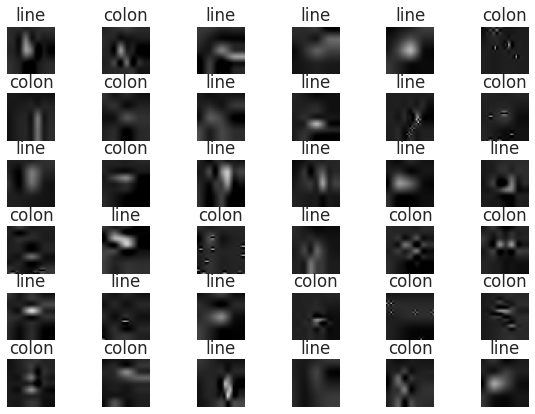

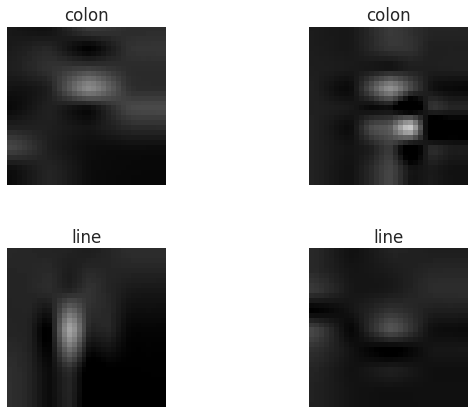

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.71930, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.71930 to 0.71970, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy improved from 0.71970 to 0.72130, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.72130

Epoch 00005: val_categorical_accuracy did not improve from 0.72130

Epoch 00006: val_categorical_accuracy improved from 0.72130 to 0.72330, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy did not improve from 0.72330

Epoch 00008: val_categorical_accuracy did not improve from 0.72330

Epoch 00009: val_categorical_accuracy did not improve from 0.72330

Epoch 00010: val_categorical_accuracy did not improve from 0.72330

Epoch 00011: val_categorical_accuracy did not improve from 0.72330

Epoch 00012: val_categorical_accuracy improved from 0.72330 to 0.72520, saving model to be

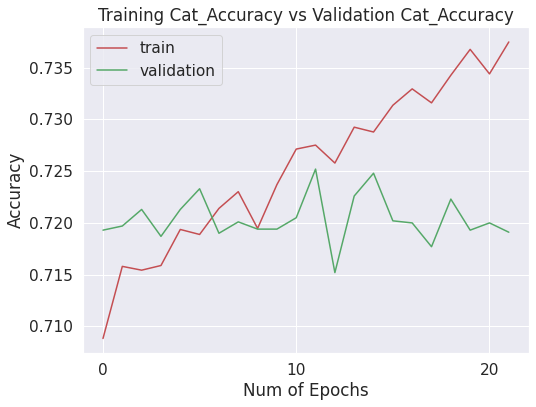

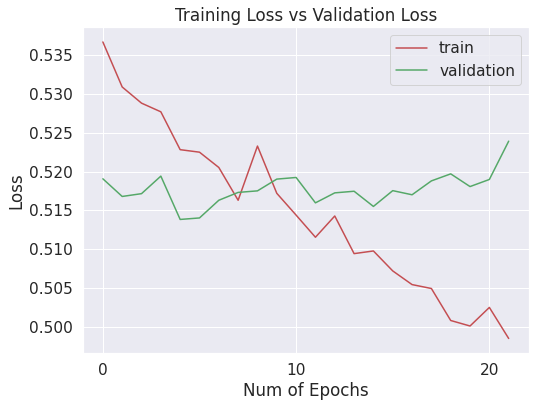

[[3672 1306]
 [1402 3620]]


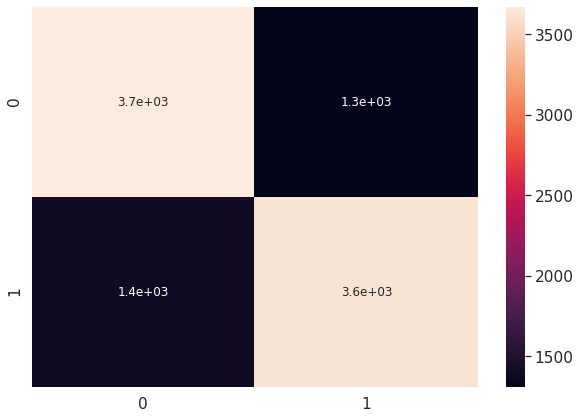

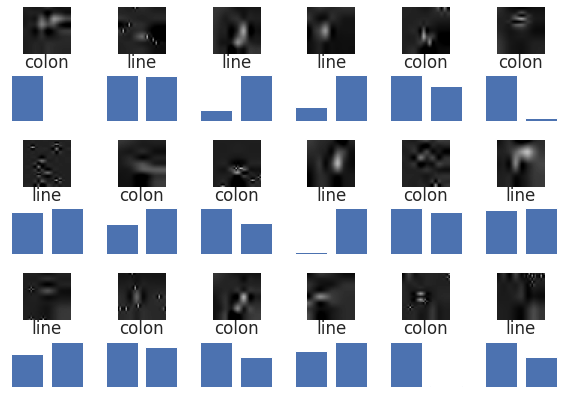

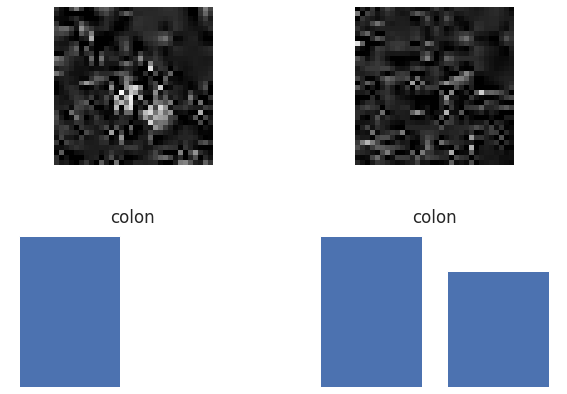

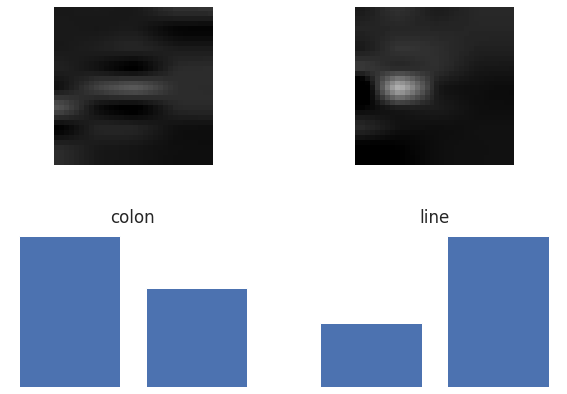

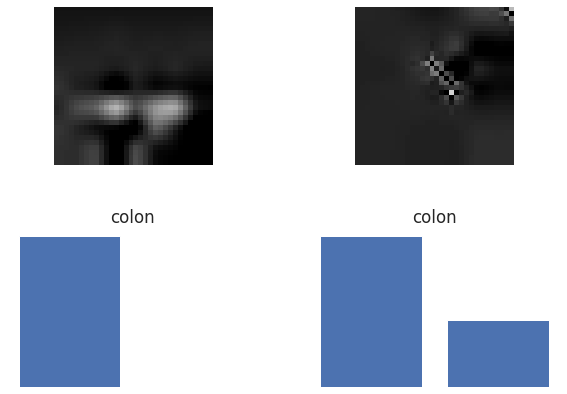

 
 
Extrapolation factor =  1.0
JPEG compression =  [32]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


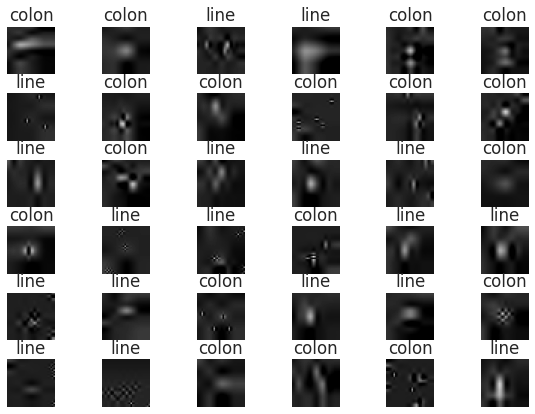

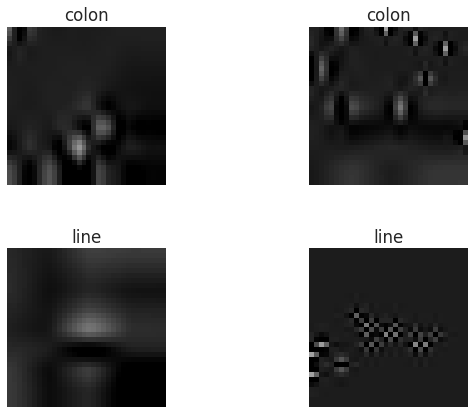

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.72070, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.72070

Epoch 00003: val_categorical_accuracy did not improve from 0.72070

Epoch 00004: val_categorical_accuracy did not improve from 0.72070

Epoch 00005: val_categorical_accuracy improved from 0.72070 to 0.72280, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy improved from 0.72280 to 0.72390, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy improved from 0.72390 to 0.72500, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy did not improve from 0.72500

Epoch 00009: val_categorical_accuracy did not improve from 0.72500

Epoch 00010: val_categorical_accuracy did not improve from 0.72500

Epoch 00011: val_categorical_accuracy improved from 0.72500 to 0.72620, saving model to best_model.h5

Epoch 00012: val_categorical_accuracy did not improve f

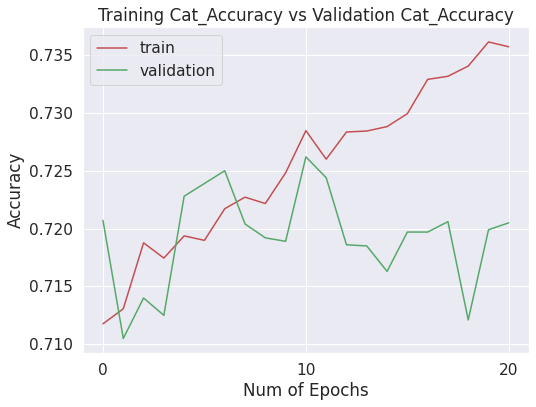

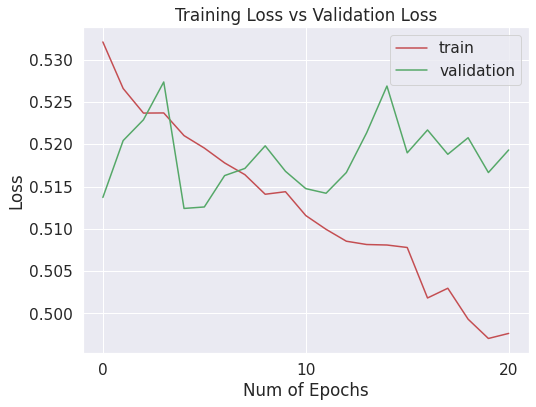

[[3799 1236]
 [1629 3336]]


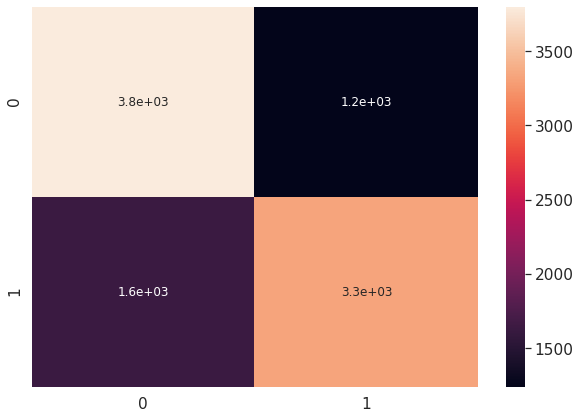

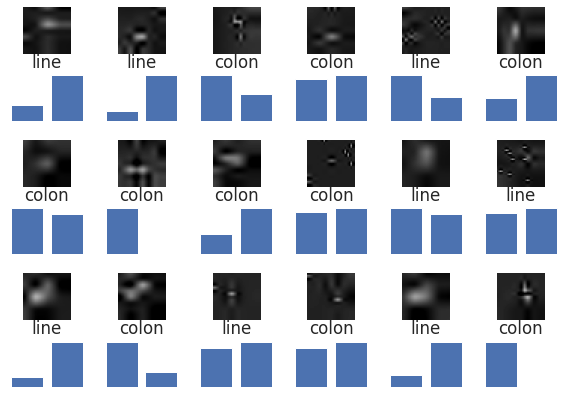

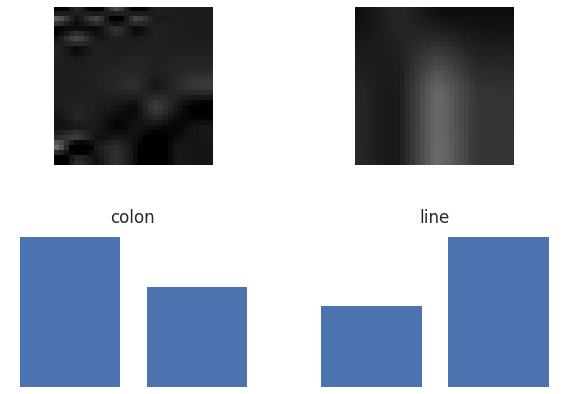

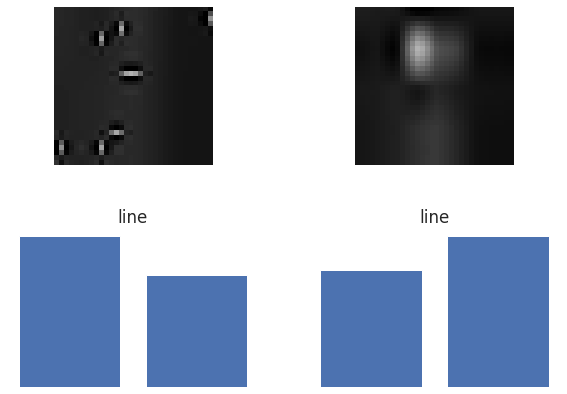

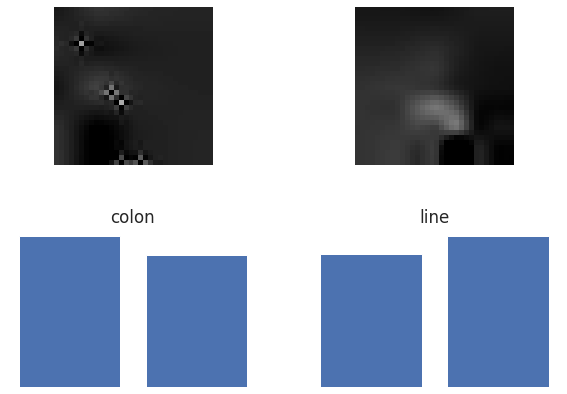

 
 
Extrapolation factor =  2.0
JPEG compression =  [1]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


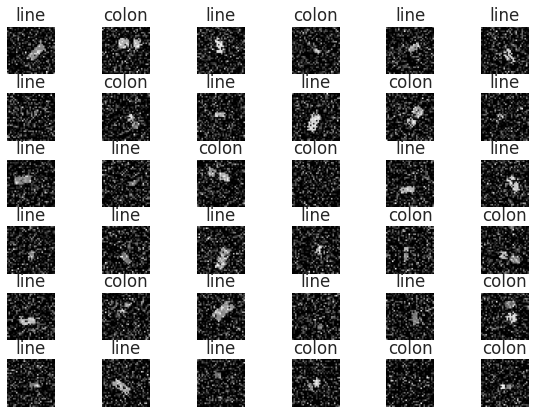

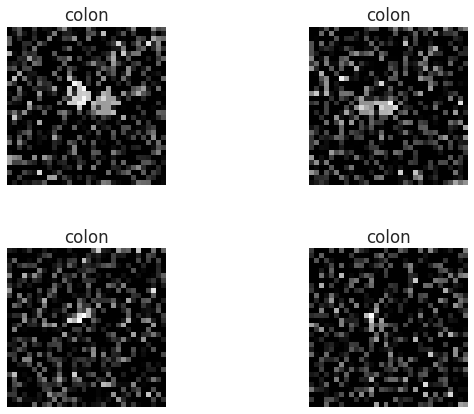

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.87570, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.87570 to 0.87840, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy improved from 0.87840 to 0.88020, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy improved from 0.88020 to 0.88300, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy improved from 0.88300 to 0.88490, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy improved from 0.88490 to 0.88700, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy improved from 0.88700 to 0.89010, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy improved from 0.89010 to 0.89050, saving model to best_model.h5

Epoch 00009: val_categorical_accuracy did not improve from 0.89050

Epoch 00010: val_categorical_accuracy did not improve from 0.89050

Epoch 00011: val_c

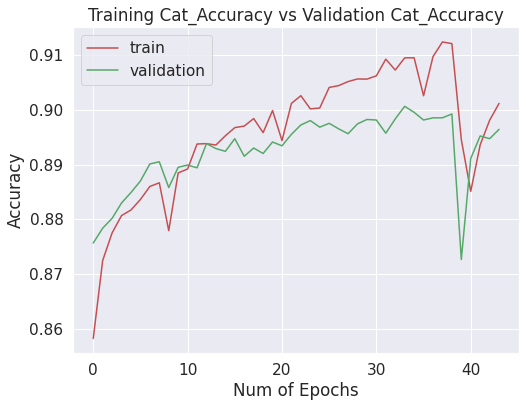

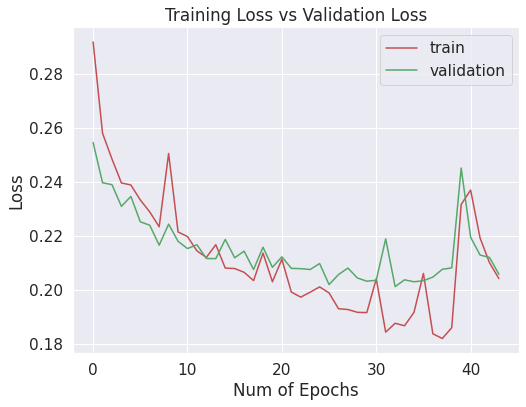

[[4377  622]
 [ 357 4644]]


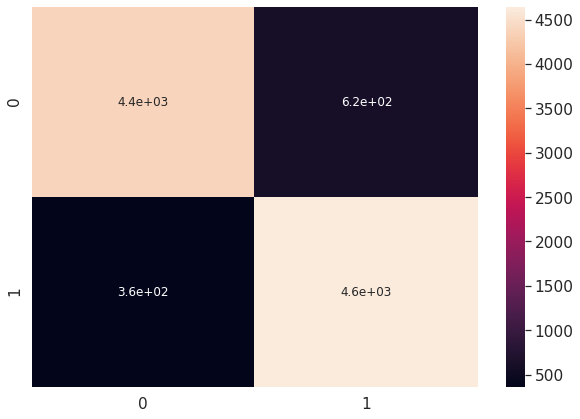

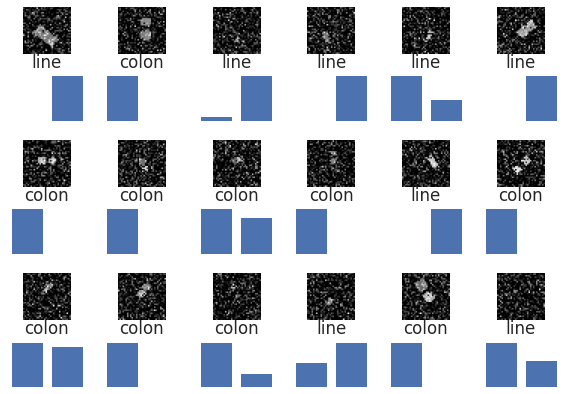

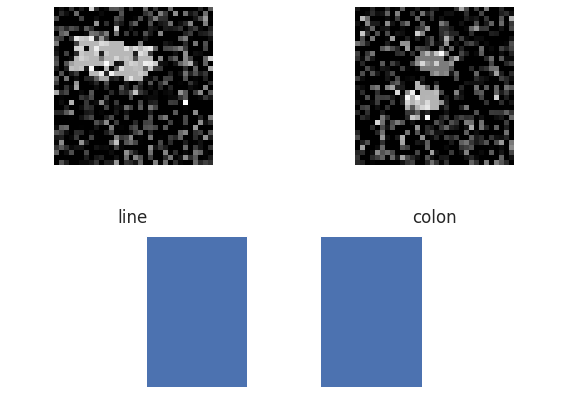

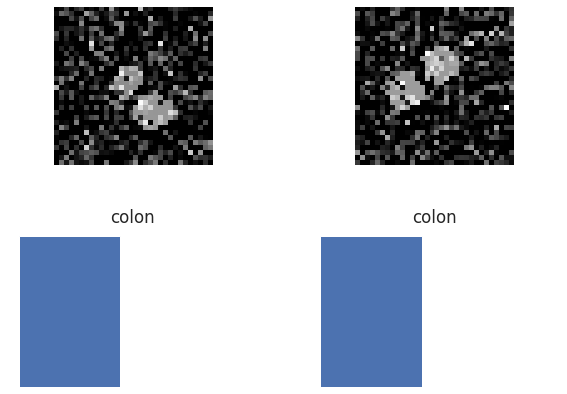

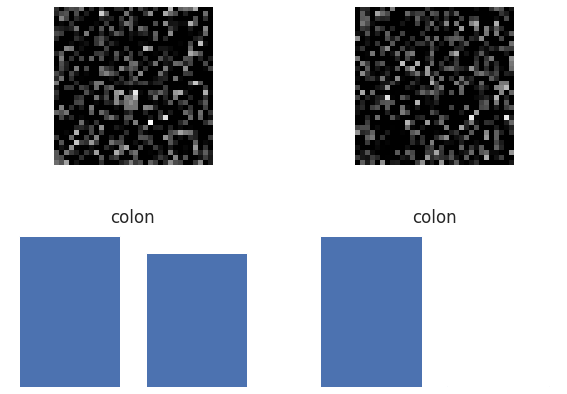

 
 
Extrapolation factor =  2.0
JPEG compression =  [2]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


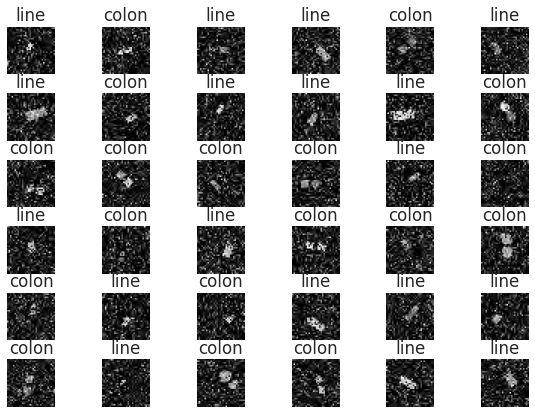

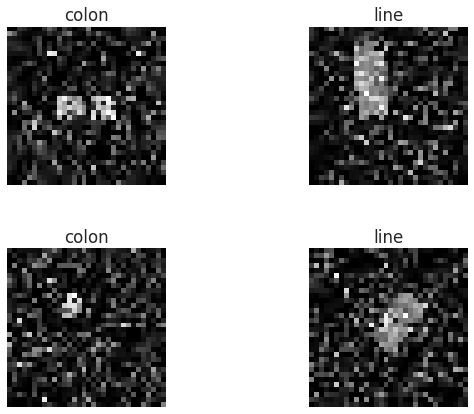

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.89490, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.89490

Epoch 00003: val_categorical_accuracy did not improve from 0.89490

Epoch 00004: val_categorical_accuracy did not improve from 0.89490

Epoch 00005: val_categorical_accuracy did not improve from 0.89490

Epoch 00006: val_categorical_accuracy did not improve from 0.89490

Epoch 00007: val_categorical_accuracy did not improve from 0.89490

Epoch 00008: val_categorical_accuracy did not improve from 0.89490

Epoch 00009: val_categorical_accuracy did not improve from 0.89490

Epoch 00010: val_categorical_accuracy did not improve from 0.89490

Epoch 00011: val_categorical_accuracy improved from 0.89490 to 0.90100, saving model to best_model.h5

Epoch 00012: val_categorical_accuracy did not improve from 0.90100

Epoch 00013: val_categorical_accuracy did not improve from 0.90100

Epoch 00014: val_categor

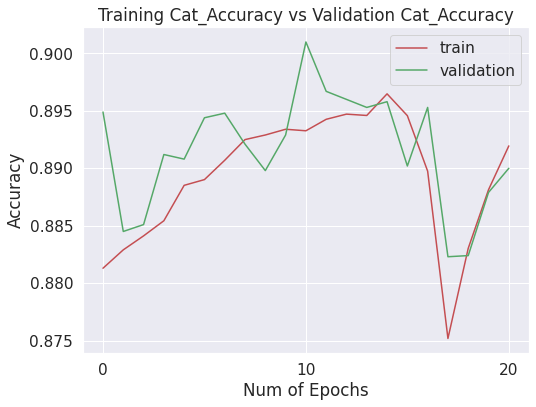

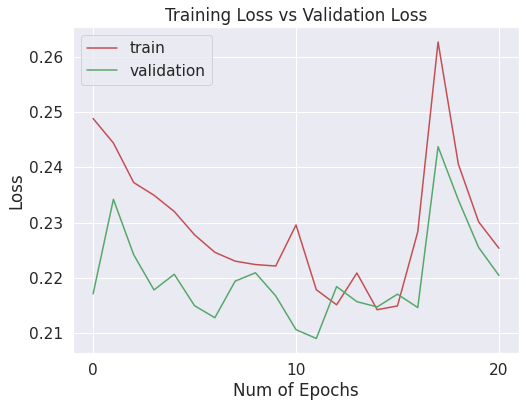

[[4298  703]
 [ 334 4665]]


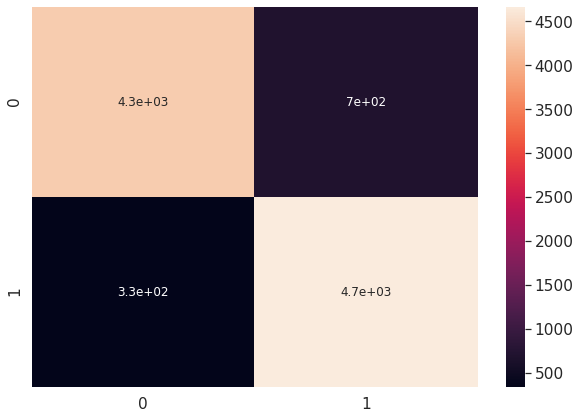

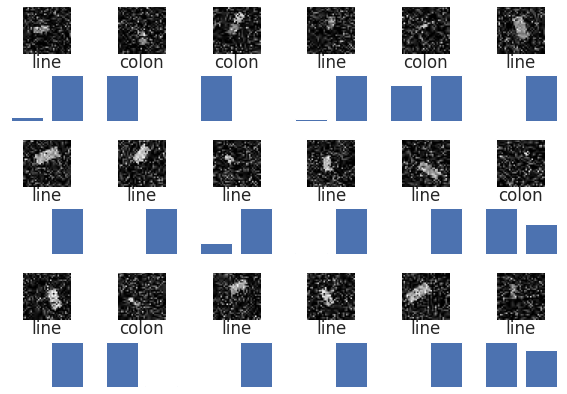

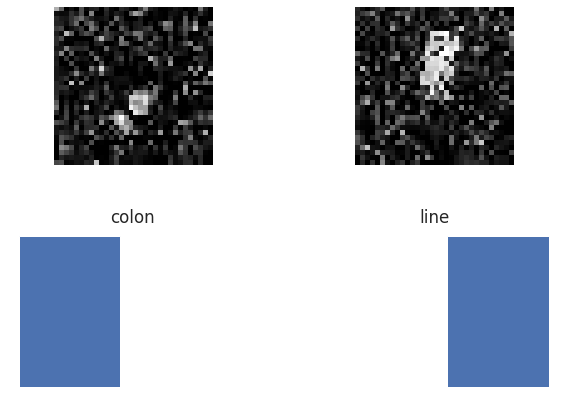

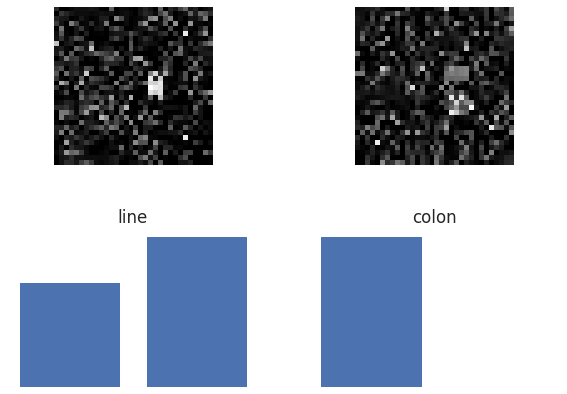

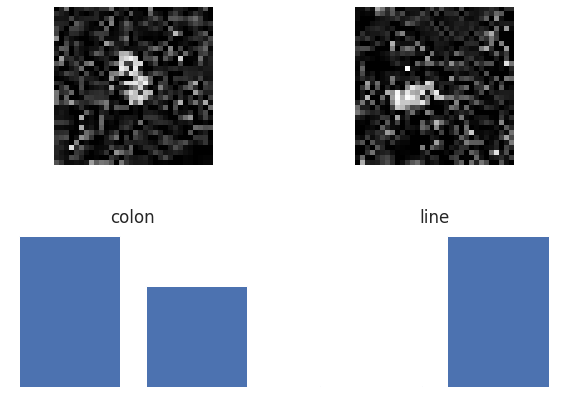

 
 
Extrapolation factor =  2.0
JPEG compression =  [4]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


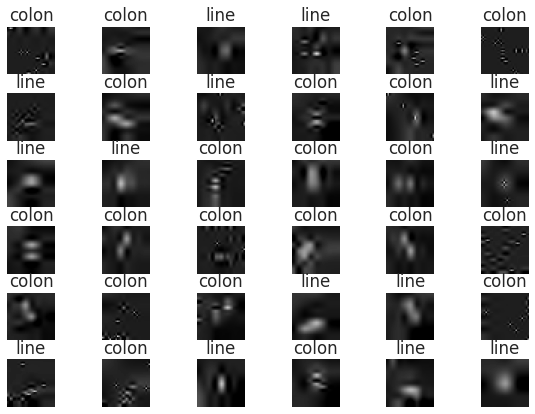

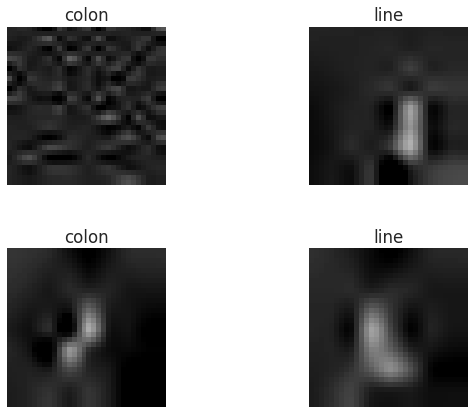

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.75120, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.75120

Epoch 00003: val_categorical_accuracy improved from 0.75120 to 0.75580, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.75580

Epoch 00005: val_categorical_accuracy did not improve from 0.75580

Epoch 00006: val_categorical_accuracy did not improve from 0.75580

Epoch 00007: val_categorical_accuracy did not improve from 0.75580

Epoch 00008: val_categorical_accuracy did not improve from 0.75580

Epoch 00009: val_categorical_accuracy did not improve from 0.75580

Epoch 00010: val_categorical_accuracy did not improve from 0.75580

Epoch 00011: val_categorical_accuracy did not improve from 0.75580

Epoch 00012: val_categorical_accuracy did not improve from 0.75580

Epoch 00013: val_categorical_accuracy did not improve from 0.75580
Epoch 00013: early stoppi

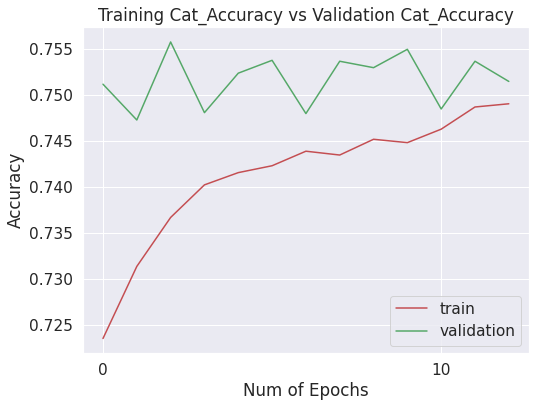

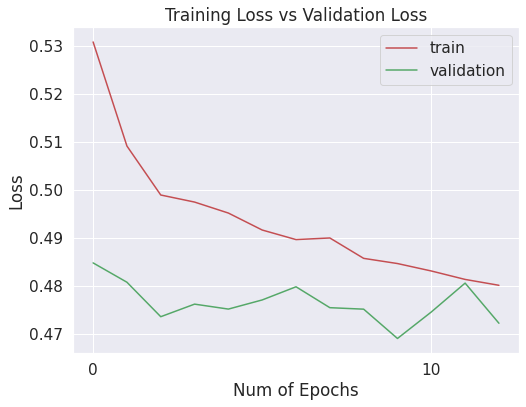

[[3671 1284]
 [1264 3781]]


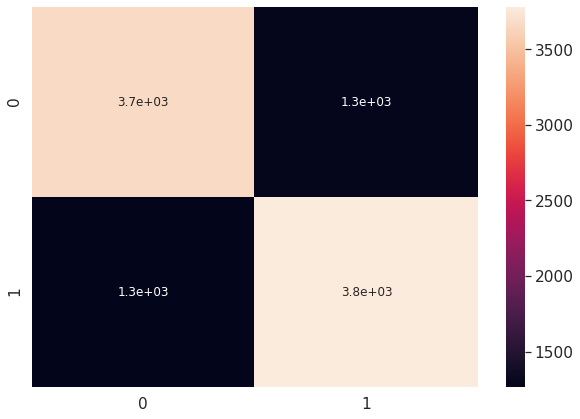

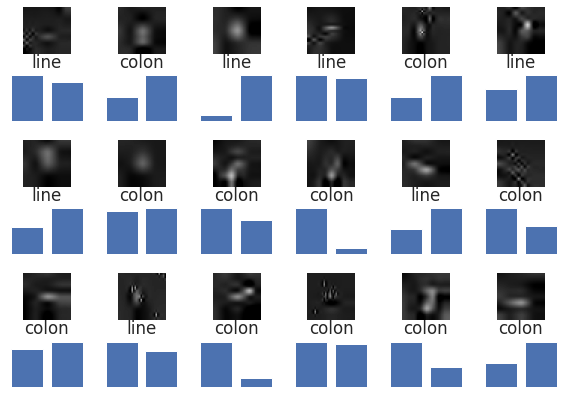

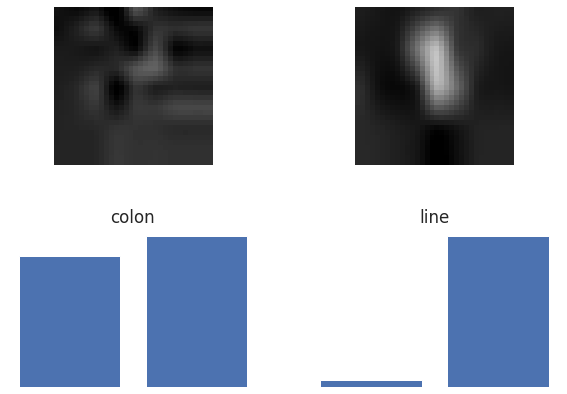

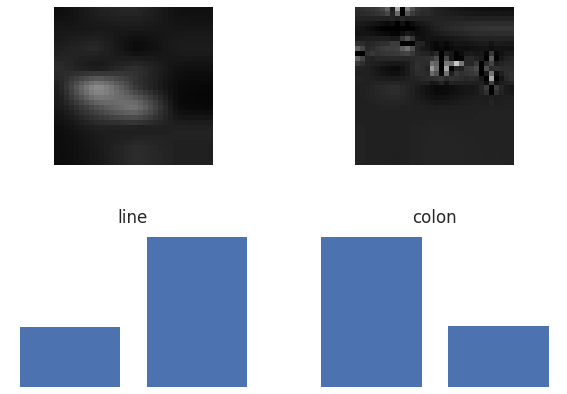

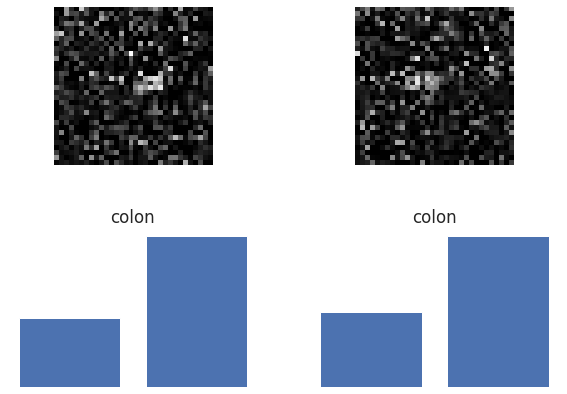

 
 
Extrapolation factor =  2.0
JPEG compression =  [8]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


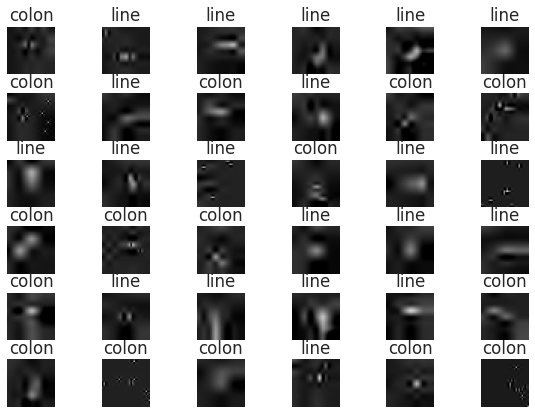

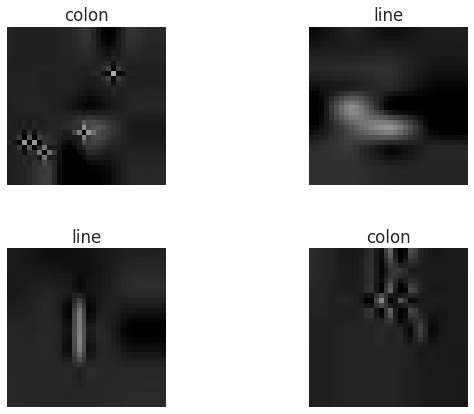

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.70580, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.70580 to 0.71190, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy improved from 0.71190 to 0.72140, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.72140

Epoch 00005: val_categorical_accuracy did not improve from 0.72140

Epoch 00006: val_categorical_accuracy improved from 0.72140 to 0.72370, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy did not improve from 0.72370

Epoch 00008: val_categorical_accuracy did not improve from 0.72370

Epoch 00009: val_categorical_accuracy did not improve from 0.72370

Epoch 00010: val_categorical_accuracy improved from 0.72370 to 0.72650, saving model to best_model.h5

Epoch 00011: val_categorical_accuracy did not improve from 0.72650

Epoch 00012: val_categorical_accuracy did not improve f

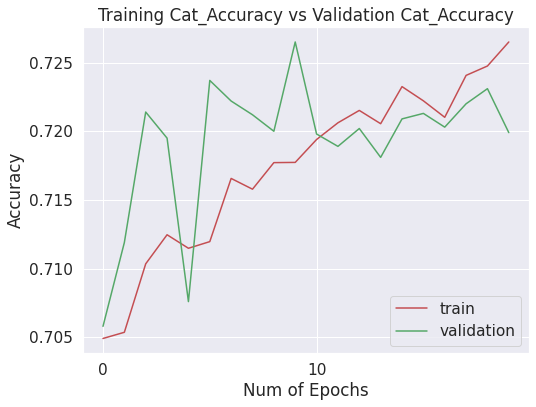

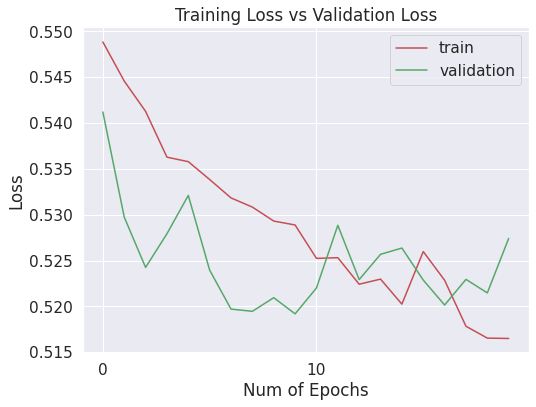

[[3796 1163]
 [1650 3391]]


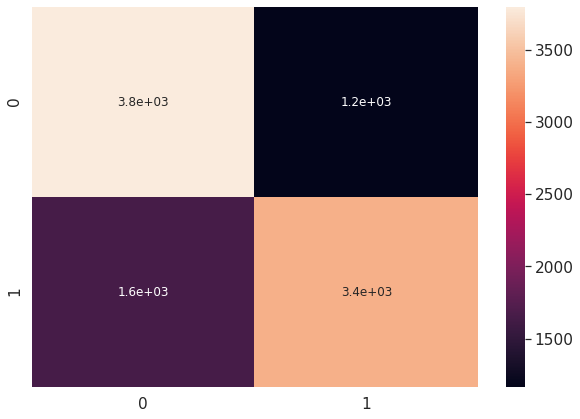

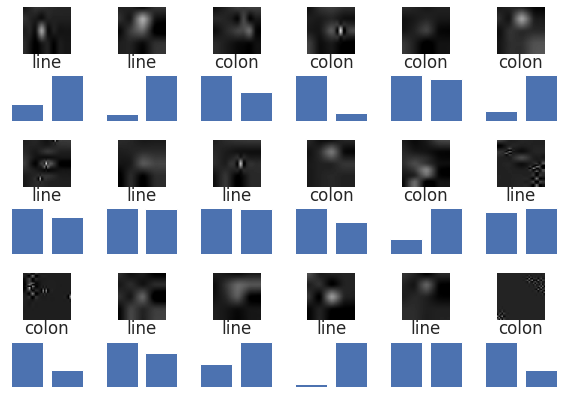

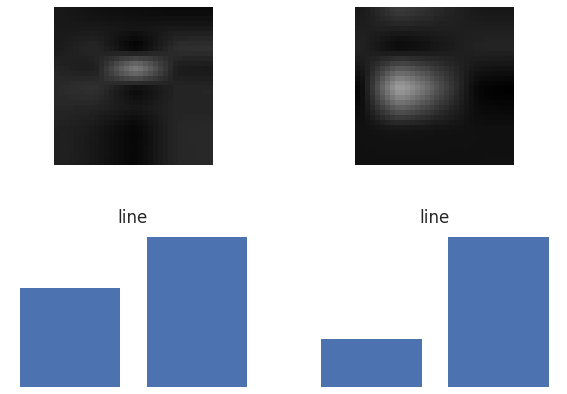

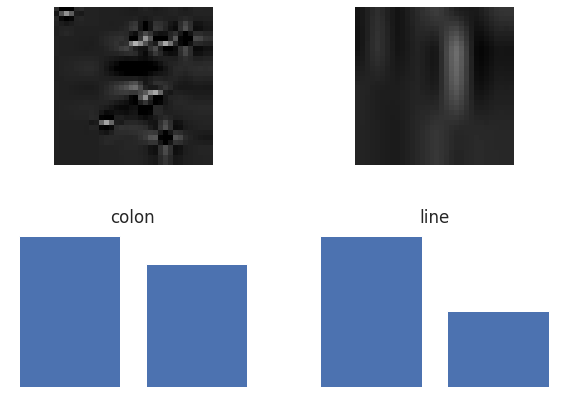

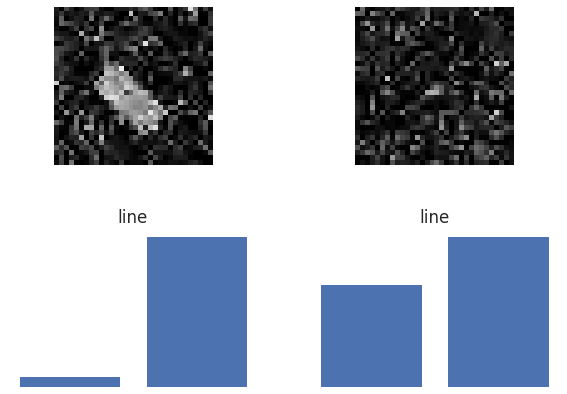

 
 
Extrapolation factor =  2.0
JPEG compression =  [16]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


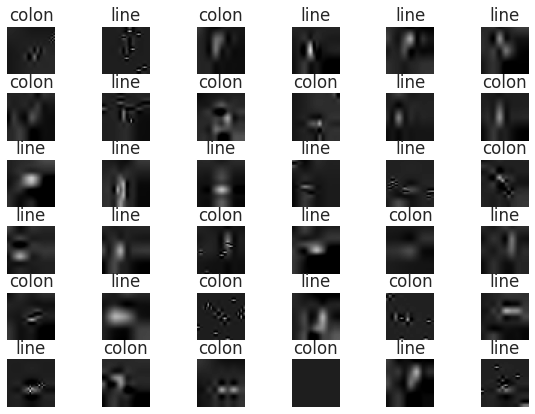

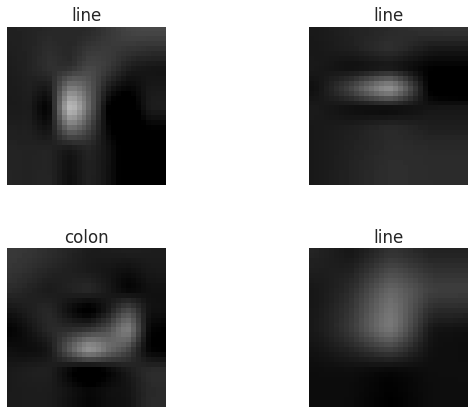

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.72370, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.72370 to 0.72440, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.72440

Epoch 00004: val_categorical_accuracy did not improve from 0.72440

Epoch 00005: val_categorical_accuracy did not improve from 0.72440

Epoch 00006: val_categorical_accuracy improved from 0.72440 to 0.72570, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy improved from 0.72570 to 0.72720, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy did not improve from 0.72720

Epoch 00009: val_categorical_accuracy did not improve from 0.72720

Epoch 00010: val_categorical_accuracy did not improve from 0.72720

Epoch 00011: val_categorical_accuracy did not improve from 0.72720

Epoch 00012: val_categorical_accuracy improved from 0.72720 to 0.72910, saving model to be

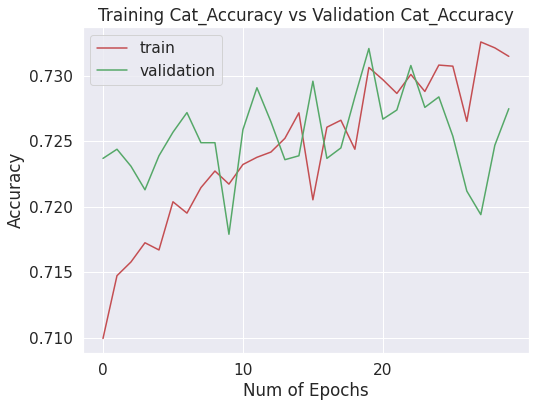

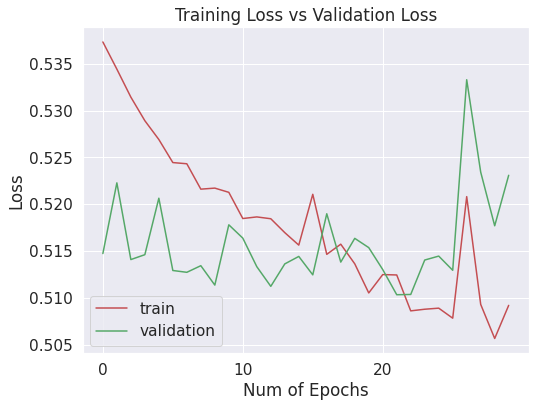

[[3569 1371]
 [1311 3749]]


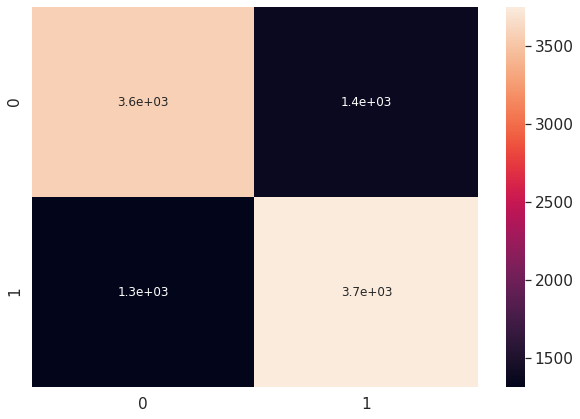

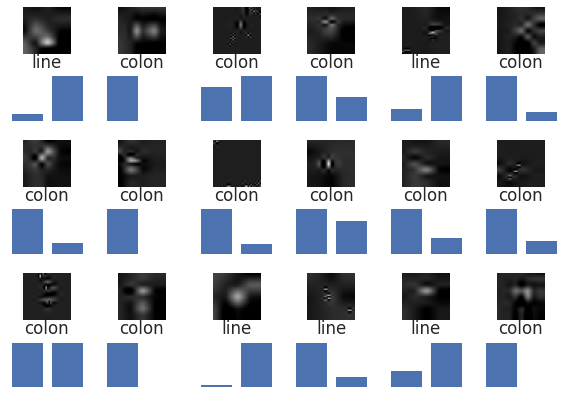

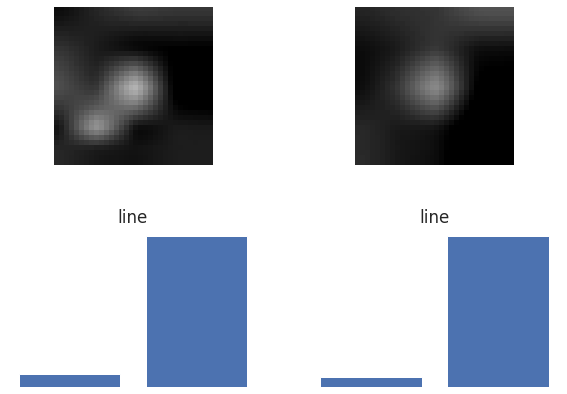

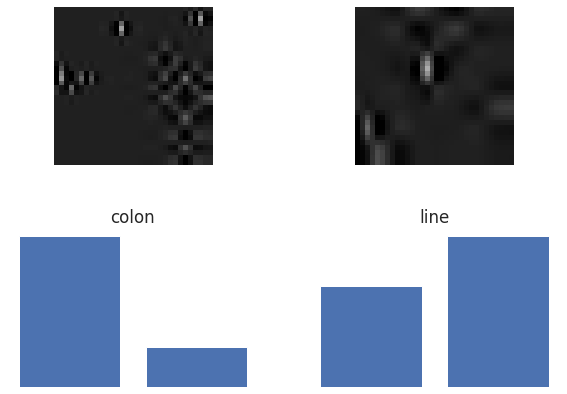

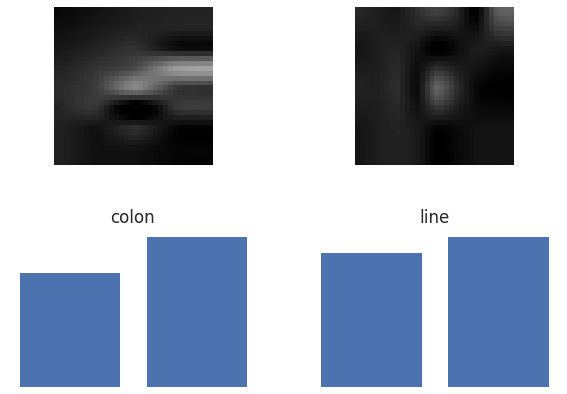

 
 
Extrapolation factor =  2.0
JPEG compression =  [32]
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


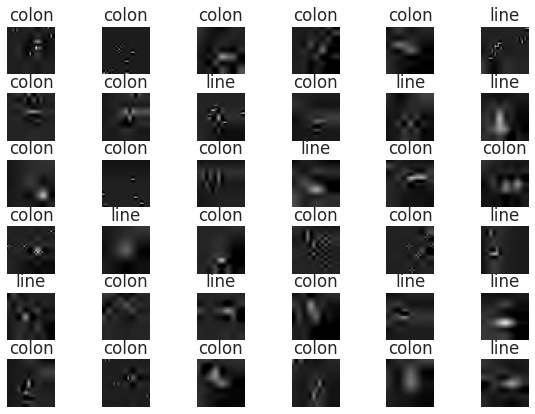

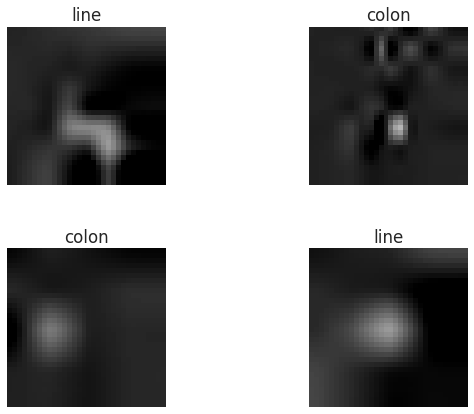

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.71370, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.71370

Epoch 00003: val_categorical_accuracy did not improve from 0.71370

Epoch 00004: val_categorical_accuracy did not improve from 0.71370

Epoch 00005: val_categorical_accuracy did not improve from 0.71370

Epoch 00006: val_categorical_accuracy improved from 0.71370 to 0.71390, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy did not improve from 0.71390

Epoch 00008: val_categorical_accuracy did not improve from 0.71390

Epoch 00009: val_categorical_accuracy did not improve from 0.71390

Epoch 00010: val_categorical_accuracy improved from 0.71390 to 0.71450, saving model to best_model.h5

Epoch 00011: val_categorical_accuracy did not improve from 0.71450

Epoch 00012: val_categorical_accuracy did not improve from 0.71450

Epoch 00013: val_categorical_accuracy improved from 0.714

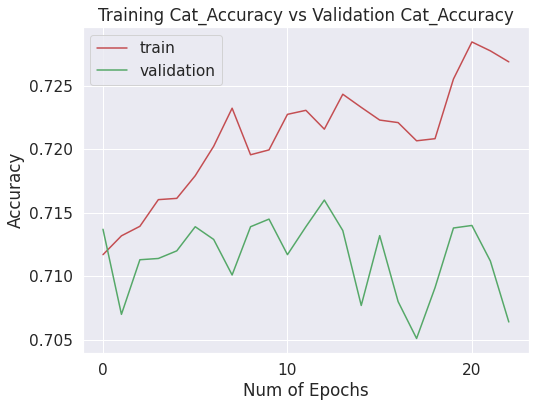

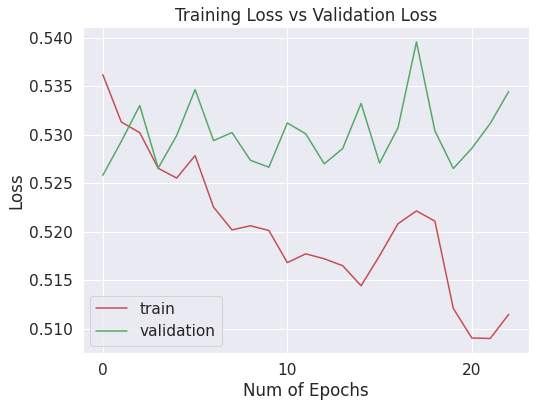

[[3810 1149]
 [1604 3437]]


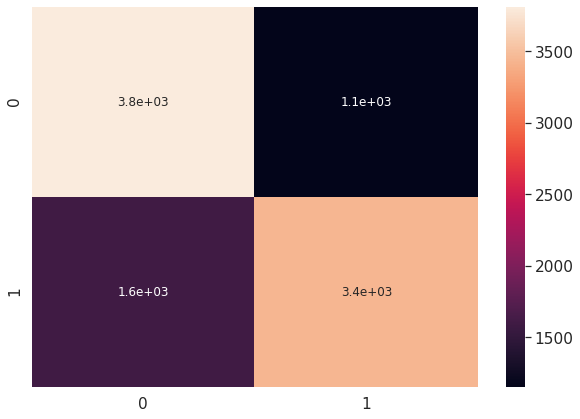

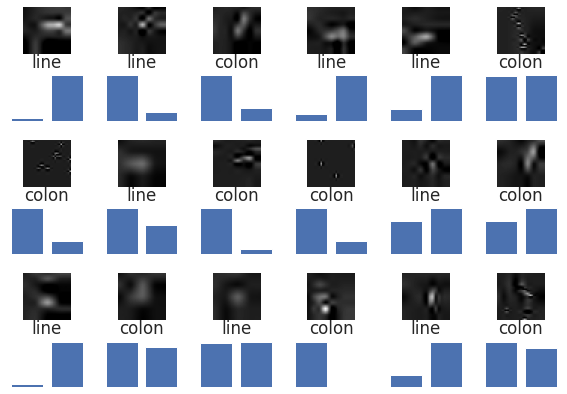

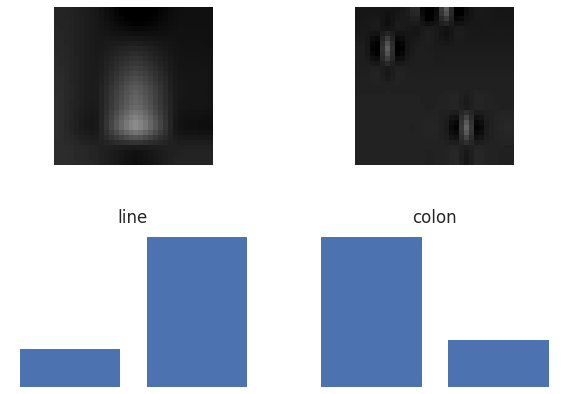

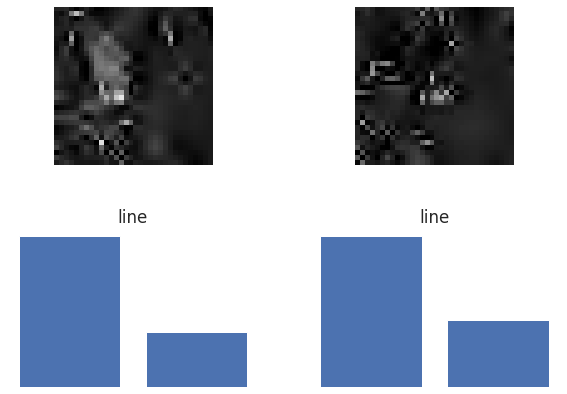

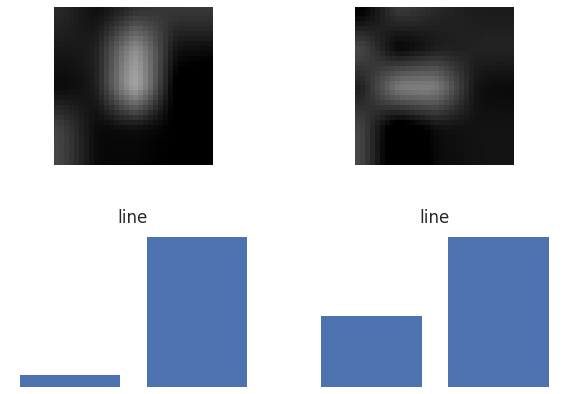

In [19]:
#acc_scores = []
#loss_scores = []

outcome = []

# Loop over extrapolations
for extrapolation_factor in extrapolation_list:

 # Loop over jpeg qualities
 if jpeg_format == 'jpeg':
   compression_list = jpeg_compression_list
 else:
  compression_list = jpeg2000_compression_list

 for jpeg_compression in compression_list:

   print(" ")
   print(" ")
   print("Extrapolation factor = ",extrapolation_factor)
   print("JPEG compression = ",jpeg_compression)
   print(" ")
   print(" ")
 
   # Generate data
   xx_train, xx_test, xx_val, yy_train, yy_test, yy_val, av_size = generate_datasets()

   #plot 100 figures (random offset)

   plot_images(6)


   plot_images(2)



   yy_train = np_utils.to_categorical(yy_train, num_classes)
   yy_test = np_utils.to_categorical(yy_test, num_classes)
   yy_val = np_utils.to_categorical(yy_val, num_classes)

   print("yy_train ",yy_train.shape)

   #Define the network
   cnn_n = base_model()
   # load the previously saved model
   try:
      cnn_n = load_model('best_model.h5')
   except:
      print("No saved model, training a new one.") 

   # patient early stopping
   es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=10)
   mc = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

   # fit model
   cnn = cnn_n.fit(xx_train, yy_train, batch_size=batch_size, epochs=epochs, validation_data=(xx_test,yy_test),shuffle=True, callbacks=[es, mc], verbose=0)
   # load the saved model
   saved_model = load_model('best_model.h5')


   # evaluate loaded model
   scores_train = saved_model.evaluate(xx_train, yy_train, verbose=0)
   scores_test  = saved_model.evaluate(xx_test,  yy_test,  verbose=0)
   scores_val   = saved_model.evaluate(xx_val,   yy_val,   verbose=0)
   print("Accuracy Train: %.2f%% , Test: %.2f%% Val: %.2f%% " % (scores_train[1]*100, scores_test[1]*100, scores_val[1]*100))

   # add scores
#   acc_scores.append(scores_val[1]*100)
#   loss_scores.append(scores_val[0]*100)
   outcome_row = (extrapolation_factor, jpeg_compression, av_size, scores_val[1]*100, scores_val[0]*100)
   outcome.append(outcome_row)

   #Plot training results
   plot_training_results(cnn)
   # Confussion matrix result
   draw_confussion_matrix()

   # Plot classified images
   plot_results(6)


   plot_results(2)
   plot_results(2)
   plot_results(2)




# **ZIP images**

In [20]:
! zip images.zip images/* 

Streaming output truncated to the last 5000 lines.
  adding: images/image_extr_1.0_jpg_[2]_100.jp2 (deflated 0%)
  adding: images/image_extr_1.0_jpg_[2]_101.jp2 (deflated 0%)
  adding: images/image_extr_1.0_jpg_[2]_102.jp2 (deflated 0%)
  adding: images/image_extr_1.0_jpg_[2]_103.jp2 (deflated 0%)
  adding: images/image_extr_1.0_jpg_[2]_104.jp2 (deflated 0%)
  adding: images/image_extr_1.0_jpg_[2]_105.jp2 (deflated 0%)
  adding: images/image_extr_1.0_jpg_[2]_106.jp2 (deflated 0%)
  adding: images/image_extr_1.0_jpg_[2]_107.jp2 (deflated 0%)
  adding: images/image_extr_1.0_jpg_[2]_108.jp2 (deflated 0%)
  adding: images/image_extr_1.0_jpg_[2]_109.jp2 (deflated 0%)
  adding: images/image_extr_1.0_jpg_[2]_10.jp2 (deflated 0%)
  adding: images/image_extr_1.0_jpg_[2]_110.jp2 (deflated 0%)
  adding: images/image_extr_1.0_jpg_[2]_111.jp2 (deflated 0%)
  adding: images/image_extr_1.0_jpg_[2]_112.jp2 (deflated 0%)
  adding: images/image_extr_1.0_jpg_[2]_113.jp2 (deflated 0%)
  adding: images/ima

# **Draw accuracy and loss vs. jpeg quality**

[(0.5, [1], 259421.966, 77.7, 44.77043414592743), (0.5, [2], 130824.26, 76.55999999999999, 45.722688269615176), (0.5, [4], 65495.274, 73.16, 50.04739267349243), (0.5, [8], 32448.224, 70.77, 54.83871903419495), (0.5, [16], 16144.166, 70.37, 54.040622892379766), (0.5, [32], 7969.2, 70.86, 53.6378613948822), (1.0, [1], 259438.096, 90.13, 20.060981069803237), (1.0, [2], 130865.35, 89.7, 21.516388674676417), (1.0, [4], 65504.634, 75.16000000000001, 47.675076861381534), (1.0, [8], 32486.47, 71.92, 52.24861012458801), (1.0, [16], 16190.744, 72.92, 51.169740457534786), (1.0, [32], 8107.068, 71.35000000000001, 51.90672367095948), (2.0, [1], 259450.366, 90.21000000000001, 20.21049823284149), (2.0, [2], 130916.724, 89.63, 21.712572755813596), (2.0, [4], 65499.104, 74.52, 48.395334210395816), (2.0, [8], 32458.312, 71.87, 52.10007745742797), (2.0, [16], 16212.93, 73.18, 51.183950691223146), (2.0, [32], 8124.822, 72.47, 51.778351058959956)]
[[1]] [77.7]
plot  0.5 [[1], [2], [4], [8], [16], [32]] [77

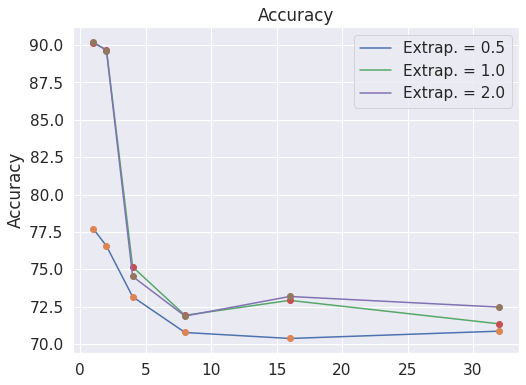

In [21]:
#plot accuracy

print(outcome)

poly=[]
compr=[]
size=[]
extrap_last = -9999
for row in range(0,len(outcome)):
   extrap = outcome[row][0]
   #print(row,outcome[row] )
   if row == 0:
     extrap_last = extrap
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])
     print(compr, poly)
   elif extrap != extrap_last:
     line, = pyl.plot(compr, poly)
     pyl.plot(compr, poly,"o")
     print("plot ",extrap_last,compr, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)
     poly=[]
     compr=[]
     size=[]
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])
     extrap_last = extrap
   elif row == len(outcome)-1:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1]) 
     size.append(outcome[row][2]) 
     line, = pyl.plot(compr, poly)
     pyl.plot(compr, poly,"o")
     print("plot ",extrap_last,compr, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)          
   else:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])



pyl.legend() 

pyl.title("Accuracy")
auxText = ""
if (jpeg_format == "JPEG2000"):
   auxText == "JPEG200 compression"
elif (jpeg_format == "jpeg"):
   auxText == "jpeg quality"  
pyl.xlabel(auxText)
pyl.ylabel("Accuracy")
pyl.show()


#print("Accuracy: ", acc_scores)
#print("JPEG compression: ", compression_list)


[(0.5, [1], 259421.966, 77.7, 44.77043414592743), (0.5, [2], 130824.26, 76.55999999999999, 45.722688269615176), (0.5, [4], 65495.274, 73.16, 50.04739267349243), (0.5, [8], 32448.224, 70.77, 54.83871903419495), (0.5, [16], 16144.166, 70.37, 54.040622892379766), (0.5, [32], 7969.2, 70.86, 53.6378613948822), (1.0, [1], 259438.096, 90.13, 20.060981069803237), (1.0, [2], 130865.35, 89.7, 21.516388674676417), (1.0, [4], 65504.634, 75.16000000000001, 47.675076861381534), (1.0, [8], 32486.47, 71.92, 52.24861012458801), (1.0, [16], 16190.744, 72.92, 51.169740457534786), (1.0, [32], 8107.068, 71.35000000000001, 51.90672367095948), (2.0, [1], 259450.366, 90.21000000000001, 20.21049823284149), (2.0, [2], 130916.724, 89.63, 21.712572755813596), (2.0, [4], 65499.104, 74.52, 48.395334210395816), (2.0, [8], 32458.312, 71.87, 52.10007745742797), (2.0, [16], 16212.93, 73.18, 51.183950691223146), (2.0, [32], 8124.822, 72.47, 51.778351058959956)]
[253.369498046875, 127.84836328125, 63.96396875, 31.6975703

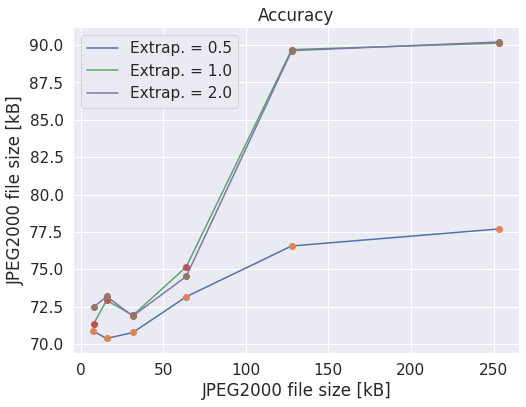

[253.369498046875, 127.84836328125, 63.96396875, 31.6975703125, 15.832939453125, 7.934396484375]
[[1], [2], [4], [8], [16], [32]]
[90.21000000000001, 89.63, 74.52, 71.87, 73.18, 72.47]


In [22]:
#plot accuracy

print(outcome)

poly=[]
compr=[]
size=[]
extrap_last = -9999
for row in range(0,len(outcome)):
   extrap = outcome[row][0]
   #print(row,outcome[row] )
   if row == 0:
     extrap_last = extrap
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)
     #print(size, poly)
   elif extrap != extrap_last:
     line, = pyl.plot(size, poly)
     pyl.plot(size, poly,"o")
     #print("plot ",extrap_last,size, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)
     poly=[]
     compr=[]
     size=[]
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)
     extrap_last = extrap
   elif row == len(outcome)-1:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1]) 
     size.append(outcome[row][2]/1024.) 
     line, = pyl.plot(size, poly)
     pyl.plot(size, poly,"o")
     #print("plot ",extrap_last,size, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label) 
     print(size)
     print(compr)
     print(poly)         
   else:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)



pyl.legend() 

pyl.title("Accuracy")
auxText = jpeg_format+" file size [kB]"
pyl.xlabel(auxText)
pyl.ylabel(auxText)
pyl.show()

print(size)
print(compr)
print(poly)
#print("Accuracy: ", acc_scores)
#print("JPEG compression: ", compression_list)


In [0]:
#plot loss
#pyl.plot(jpeg_compression_list, loss_scores)
#pyl.plot(jpeg_compression_list, loss_scores,'o')
#pyl.title("Loss")
#pyl.xlabel("JPEG quality")
#pyl.ylabel("Loss")
#pyl.show()